In [2]:
import os
import numpy as np
import pandas as pd
import rasterio
from rasterio.transform import from_bounds
from rasterio.warp import reproject, Resampling
from rasterio.enums import Resampling
from rasterio.plot import show
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap
import seaborn as sns
from scipy import ndimage
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set up directories
os.makedirs('output', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('data', exist_ok=True)

# Configuration will be set by user choice
MODEL_PATH = 'models/fire_prediction_model.pkl'
FORCE_RETRAIN = False

print("📦 Libraries imported successfully!")
print("📁 Directories created/verified!")
print("⚙️  System ready for user input...")
print()

📦 Libraries imported successfully!
📁 Directories created/verified!
⚙️  System ready for user input...



In [3]:
# 🔥 FOREST FIRE PREDICTION SYSTEM 🔥
print("=" * 60)
print("🔥 WELCOME TO FOREST FIRE PREDICTION SYSTEM 🔥")
print("=" * 60)
print()

# Simple user choice system
print("📋 PLEASE SELECT AN OPTION:")
print("1️⃣  Train New Model (Will take time but gives fresh results)")
print("2️⃣  Use Existing Model (Fast - loads pre-trained model)")
print()

# Get user choice
while True:
    try:
        user_option = input("Enter your choice (1 or 2): ").strip()
        if user_option == "1":
            RETRAIN_MODEL = True
            print("✅ You selected: TRAIN NEW MODEL")
            print("🔄 The system will train a new model with current data")
            break
        elif user_option == "2":
            RETRAIN_MODEL = False
            print("✅ You selected: USE EXISTING MODEL")
            print("📂 The system will load existing model (if available)")
            break
        else:
            print("❌ Invalid choice! Please enter 1 or 2")
    except KeyboardInterrupt:
        print("\n⚠️  Using default option: USE EXISTING MODEL")
        RETRAIN_MODEL = False
        break
    except:
        print("❌ Please enter 1 or 2")

print()
print("🚀 Starting the system...")
print("=" * 60)
print()

🔥 WELCOME TO FOREST FIRE PREDICTION SYSTEM 🔥

📋 PLEASE SELECT AN OPTION:
1️⃣  Train New Model (Will take time but gives fresh results)
2️⃣  Use Existing Model (Fast - loads pre-trained model)

✅ You selected: USE EXISTING MODEL
📂 The system will load existing model (if available)

🚀 Starting the system...



# 🔥 Forest Fire Prediction & Spread Simulation

## 🚀 How to Use This System

When you run the first cell, you'll be prompted to choose:

### **Option 1: Train New Model**
- ✅ **Fresh training** with current data
- ✅ **Most accurate** results
- ✅ **Recommended for first-time users**
- ⚠️ **Takes time** (several minutes)

### **Option 2: Use Existing Model**
- ✅ **Fast execution** (instant results)
- ✅ **Uses pre-trained model**
- ✅ **Good for quick analysis**
- ⚠️ **Requires existing model** (will train if none found)

---

## 📋 Quick Start

1. **Run the first cell** - You'll see a prompt asking for your choice
2. **Enter 1** to train a new model OR **Enter 2** to use existing model
3. **Run all cells** to execute the complete pipeline
4. **Check the output folder** for results

---

## 📁 Output Files

The system generates:
- Fire risk prediction maps
- Fire spread simulations
- Model performance metrics
- Comprehensive visualizations

In [4]:
class RasterProcessor:
    def __init__(self, target_resolution=30):
        self.target_resolution = target_resolution
        self.raster_files = {
            'temperature': 'data/temperature.tif',
            'humidity': 'data/humidity.tif',
            'wind_speed': 'data/wind_speed.tif',
            'wind_dir': 'data/wind_dir.tif',
            'rainfall': 'data/rainfall.tif',
            'dem': 'data/dem.tif',
            'lulc': 'data/lulc.tif',
            'roads': 'data/roads.tif',
            'settlements': 'data/settlements.tif',
            'fire_labels': 'data/fire_labels.tif'
        }
        
    def load_raster(self, filepath):
        """Load raster data using rasterio"""
        try:
            with rasterio.open(filepath) as src:
                data = src.read(1)
                transform = src.transform
                crs = src.crs
                profile = src.profile
            return data, transform, crs, profile
        except Exception as e:
            print(f"Error loading {filepath}: {e}")
            return None, None, None, None
    
    def resample_raster(self, data, transform, profile, target_resolution):
        """Resample raster to target resolution"""
        original_res = abs(transform.a)
        
        if abs(original_res - target_resolution) < 1e-6:
            return data, transform, profile
        
        scale_factor = original_res / target_resolution
        
        new_height = max(1, int(data.shape[0] * scale_factor))
        new_width = max(1, int(data.shape[1] * scale_factor))
        
        # If dimensions are too small, just return original data
        if new_height <= 1 or new_width <= 1:
            return data, transform, profile
        
        resampled_data = np.zeros((new_height, new_width))
        
        dst_transform = rasterio.transform.from_bounds(
            transform.c, transform.f + transform.e * data.shape[0],
            transform.c + transform.a * data.shape[1], transform.f,
            new_width, new_height
        )
        
        reproject(
            source=data,
            destination=resampled_data,
            src_transform=transform,
            src_crs=profile['crs'],
            dst_transform=dst_transform,
            dst_crs=profile['crs'],
            resampling=Resampling.bilinear
        )
        
        profile.update({
            'height': new_height,
            'width': new_width,
            'transform': dst_transform
        })
        
        return resampled_data, dst_transform, profile
    
    def calculate_slope_aspect(self, dem):
        """Calculate slope and aspect from DEM"""
        grad_x = np.gradient(dem, axis=1)
        grad_y = np.gradient(dem, axis=0)
        
        slope = np.sqrt(grad_x**2 + grad_y**2)
        aspect = np.arctan2(grad_y, grad_x)
        
        return slope, aspect
    
    def visualize_raster(self, data, title, cmap='viridis'):
        """Visualize raster data"""
        plt.figure(figsize=(10, 8))
        plt.imshow(data, cmap=cmap)
        plt.colorbar()
        plt.title(title)
        plt.show()

processor = RasterProcessor()
print("RasterProcessor class created successfully!")

RasterProcessor class created successfully!


In [5]:
def create_sample_data():
    """Create sample GeoTIFF files for testing"""
    
    np.random.seed(42)
    height, width = 200, 200
    
    transform = rasterio.transform.from_bounds(
        -120.0, 35.0, -119.0, 36.0, width, height
    )
    
    profile = {
        'driver': 'GTiff',
        'height': height,
        'width': width,
        'count': 1,
        'dtype': 'float32',
        'crs': 'EPSG:4326',
        'transform': transform,
        'compress': 'lzw'
    }
    
    sample_data = {
        'temperature': np.random.uniform(15, 35, (height, width)),
        'humidity': np.random.uniform(20, 80, (height, width)),
        'wind_speed': np.random.uniform(0, 20, (height, width)),
        'wind_dir': np.random.uniform(0, 360, (height, width)),
        'rainfall': np.random.uniform(0, 50, (height, width)),
        'dem': np.random.uniform(100, 2000, (height, width)),
        'lulc': np.random.randint(1, 10, (height, width)),
        'roads': np.random.uniform(0, 5000, (height, width)),
        'settlements': np.random.uniform(0, 10000, (height, width)),
        'fire_labels': np.random.choice([0, 1], (height, width), p=[0.9, 0.1])
    }
    
    for name, data in sample_data.items():
        filepath = f'data/{name}.tif'
        with rasterio.open(filepath, 'w', **profile) as dst:
            dst.write(data.astype(np.float32), 1)
    
    print("Sample data created successfully!")

create_sample_data()

Sample data created successfully!


# 🎯 Enhanced Dataset Generation

This section generates realistic forest fire datasets with proper spatial correlations and environmental patterns that mimic real-world conditions.

In [6]:
def generate_realistic_dataset(height=500, width=500, num_fire_events=15, seed=42):
    """
    Generate realistic forest fire dataset with spatial correlations and environmental patterns
    
    Parameters:
    - height, width: Dimensions of the raster data
    - num_fire_events: Number of fire events to simulate
    - seed: Random seed for reproducibility
    """
    
    np.random.seed(seed)
    
    # Define coordinate bounds (example area in California)
    min_lon, max_lon = -121.0, -119.0
    min_lat, max_lat = 36.0, 38.0
    
    transform = rasterio.transform.from_bounds(
        min_lon, min_lat, max_lon, max_lat, width, height
    )
    
    profile = {
        'driver': 'GTiff',
        'height': height,
        'width': width,
        'count': 1,
        'dtype': 'float32',
        'crs': 'EPSG:4326',
        'transform': transform,
        'compress': 'lzw'
    }
    
    print(f"Generating {height}x{width} realistic dataset with {num_fire_events} fire events...")
    
    # Create coordinate grids
    x = np.linspace(0, width-1, width)
    y = np.linspace(0, height-1, height)
    X, Y = np.meshgrid(x, y)
    
    # 1. Generate realistic DEM with mountain ranges
    print("Generating realistic terrain...")
    dem = np.zeros((height, width))
    
    # Add multiple mountain ranges
    for i in range(3):
        center_x = np.random.uniform(width*0.2, width*0.8)
        center_y = np.random.uniform(height*0.2, height*0.8)
        amplitude = np.random.uniform(800, 1500)
        sigma_x = np.random.uniform(width*0.1, width*0.3)
        sigma_y = np.random.uniform(height*0.1, height*0.3)
        
        mountain = amplitude * np.exp(-((X-center_x)**2/(2*sigma_x**2) + (Y-center_y)**2/(2*sigma_y**2)))
        dem += mountain
    
    # Add base elevation and noise
    dem += 200 + np.random.normal(0, 50, (height, width))
    dem = np.clip(dem, 0, 3000)
    
    # 2. Generate temperature with elevation correlation
    print("Generating temperature data...")
    base_temp = 25  # Base temperature at sea level
    lapse_rate = 0.006  # Temperature decreases with elevation
    temp_seasonal = np.random.normal(0, 5)  # Seasonal variation
    
    temperature = base_temp - (dem * lapse_rate) + temp_seasonal
    # Add spatial variation
    temp_gradient_x = np.linspace(-2, 2, width)
    temp_gradient_y = np.linspace(-1, 1, height)
    temp_grid_x, temp_grid_y = np.meshgrid(temp_gradient_x, temp_gradient_y)
    temperature += temp_grid_x + temp_grid_y
    
    # Add noise
    temperature += np.random.normal(0, 2, (height, width))
    temperature = np.clip(temperature, -10, 45)
    
    # 3. Generate humidity (inversely correlated with temperature)
    print("Generating humidity data...")
    base_humidity = 60
    humidity = base_humidity - (temperature - 20) * 1.5
    # Add elevation effect (higher humidity at higher elevations)
    humidity += (dem - 500) * 0.01
    # Add spatial patterns
    humidity += np.sin(X/50) * 5 + np.cos(Y/40) * 3
    humidity += np.random.normal(0, 5, (height, width))
    humidity = np.clip(humidity, 10, 95)
    
    # 4. Generate wind speed (higher at higher elevations and ridges)
    print("Generating wind data...")
    # Calculate slope for wind acceleration
    grad_x = np.gradient(dem, axis=1)
    grad_y = np.gradient(dem, axis=0)
    slope = np.sqrt(grad_x**2 + grad_y**2)
    
    wind_speed = 5 + (dem / 500) * 3 + (slope / 10) * 2
    # Add weather patterns
    wind_speed += np.sin(X/30) * 2 + np.cos(Y/25) * 1.5
    wind_speed += np.random.normal(0, 2, (height, width))
    wind_speed = np.clip(wind_speed, 0, 25)
    
    # 5. Generate wind direction (influenced by topography)
    print("Generating wind direction...")
    # Base wind direction (prevailing winds)
    base_wind_dir = 225  # Southwest winds
    wind_dir = np.full((height, width), base_wind_dir, dtype=np.float64)
    
    # Add topographic influence
    aspect = np.arctan2(grad_y, grad_x) * 180 / np.pi
    wind_dir += aspect * 0.3  # Terrain channeling effect
    
    # Add turbulence
    wind_dir += np.random.normal(0, 30, (height, width))
    wind_dir = wind_dir % 360
    
    # 6. Generate rainfall (correlated with elevation and humidity)
    print("Generating rainfall data...")
    # Orographic effect (more rain at higher elevations)
    rainfall = 10 + (dem / 200) * 5 + (humidity / 10) * 2
    # Add storm patterns
    for i in range(3):
        storm_x = np.random.uniform(0, width)
        storm_y = np.random.uniform(0, height)
        storm_intensity = np.random.uniform(15, 40)
        storm_radius = np.random.uniform(50, 100)
        
        storm_dist = np.sqrt((X - storm_x)**2 + (Y - storm_y)**2)
        storm_effect = storm_intensity * np.exp(-storm_dist / storm_radius)
        rainfall += storm_effect
    
    rainfall += np.random.normal(0, 3, (height, width))
    rainfall = np.clip(rainfall, 0, 100)
    
    # 7. Generate land use/land cover (elevation and slope dependent)
    print("Generating land use/land cover...")
    lulc = np.zeros((height, width))
    
    # Water bodies (low elevation)
    water_mask = (dem < 300) & (slope < 2)
    lulc[water_mask] = 1
    
    # Urban areas (moderate elevation, low slope)
    urban_mask = (dem > 250) & (dem < 800) & (slope < 5)
    urban_prob = 0.05 + (1 / (1 + np.exp(-(dem - 400) / 100))) * 0.1
    urban_random = np.random.random((height, width))
    urban_areas = urban_mask & (urban_random < urban_prob)
    lulc[urban_areas] = 2
    
    # Agricultural areas (low to moderate elevation, low slope)
    ag_mask = (dem > 200) & (dem < 600) & (slope < 10) & (lulc == 0)
    ag_prob = 0.15
    ag_random = np.random.random((height, width))
    ag_areas = ag_mask & (ag_random < ag_prob)
    lulc[ag_areas] = 3
    
    # Grasslands (moderate elevation)
    grass_mask = (dem > 300) & (dem < 1200) & (slope < 15) & (lulc == 0)
    grass_prob = 0.3
    grass_random = np.random.random((height, width))
    grass_areas = grass_mask & (grass_random < grass_prob)
    lulc[grass_areas] = 4
    
    # Forest (higher elevation, moderate slope)
    forest_mask = (dem > 400) & (dem < 2000) & (slope < 30) & (lulc == 0)
    forest_prob = 0.6
    forest_random = np.random.random((height, width))
    forest_areas = forest_mask & (forest_random < forest_prob)
    lulc[forest_areas] = 5
    
    # Shrubland (higher elevation, steeper slope)
    shrub_mask = (dem > 600) & (slope > 10) & (lulc == 0)
    lulc[shrub_mask] = 6
    
    # Bare rock/alpine (very high elevation)
    rock_mask = (dem > 2000) | (slope > 35)
    lulc[rock_mask] = 7
    
    # 8. Generate roads (connecting urban areas, following valleys)
    print("Generating road network...")
    roads = np.full((height, width), 10000.0)  # Initialize with large distances
    
    # Create main roads connecting urban centers
    urban_centers = np.where(lulc == 2)
    if len(urban_centers[0]) > 0:
        # Select major urban centers
        major_centers = []
        for i in range(min(5, len(urban_centers[0]))):
            idx = np.random.choice(len(urban_centers[0]))
            major_centers.append((urban_centers[0][idx], urban_centers[1][idx]))
        
        # Connect centers with roads
        for i in range(len(major_centers)):
            for j in range(i+1, len(major_centers)):
                y1, x1 = major_centers[i]
                y2, x2 = major_centers[j]
                
                # Simple linear interpolation for road path
                steps = max(abs(x2-x1), abs(y2-y1))
                if steps > 0:
                    for step in range(steps):
                        x = int(x1 + (x2-x1) * step / steps)
                        y = int(y1 + (y2-y1) * step / steps)
                        
                        # Add road with some width
                        for dy in range(-2, 3):
                            for dx in range(-2, 3):
                                ny, nx = y + dy, x + dx
                                if 0 <= ny < height and 0 <= nx < width:
                                    roads[ny, nx] = min(roads[ny, nx], 0)
    
    # Calculate distance to roads
    from scipy.ndimage import distance_transform_edt
    road_mask = roads == 0
    if np.any(road_mask):
        roads = distance_transform_edt(~road_mask) * 30  # Convert to meters (30m resolution)
    
    # 9. Generate settlements (distance to urban areas)
    print("Generating settlement proximity...")
    urban_mask = lulc == 2
    if np.any(urban_mask):
        settlements = distance_transform_edt(~urban_mask) * 30  # Convert to meters
    else:
        settlements = np.full((height, width), 5000.0)
    
    # 10. Generate fire labels with realistic patterns
    print("Generating fire occurrence labels...")
    fire_labels = np.zeros((height, width))
    
    # Fire risk factors
    fire_risk = np.zeros((height, width))
    
    # Temperature effect (higher temp = higher risk)
    fire_risk += (temperature - 15) / 30 * 0.3
    
    # Humidity effect (lower humidity = higher risk)
    fire_risk += (80 - humidity) / 70 * 0.2
    
    # Wind effect (higher wind = higher risk)
    fire_risk += wind_speed / 25 * 0.1
    
    # Drought effect (low rainfall = higher risk)
    fire_risk += (30 - rainfall) / 30 * 0.2
    
    # Vegetation effect (forest/shrub = higher risk)
    veg_risk = np.zeros_like(lulc)
    veg_risk[lulc == 5] = 0.1  # Forest
    veg_risk[lulc == 6] = 0.15  # Shrubland
    veg_risk[lulc == 4] = 0.05  # Grassland
    fire_risk += veg_risk
    
    # Human activity effect (closer to roads/settlements = higher risk)
    fire_risk += np.exp(-roads / 1000) * 0.05
    fire_risk += np.exp(-settlements / 2000) * 0.03
    
    # Normalize fire risk
    fire_risk = np.clip(fire_risk, 0, 1)
    
    # Generate fire events
    for event in range(num_fire_events):
        # Select fire starting point based on risk
        risk_flat = fire_risk.flatten()
        risk_prob = risk_flat / np.sum(risk_flat)
        
        start_idx = np.random.choice(len(risk_flat), p=risk_prob)
        start_y, start_x = np.unravel_index(start_idx, (height, width))
        
        # Fire spread simulation (simple)
        fire_size = np.random.uniform(50, 200)  # Fire radius
        fire_intensity = np.random.uniform(0.3, 0.8)
        
        # Create fire spread pattern
        fire_dist = np.sqrt((X - start_x)**2 + (Y - start_y)**2)
        fire_spread = np.exp(-fire_dist / fire_size) * fire_intensity
        
        # Wind direction influence on fire spread
        wind_influence = np.cos(np.radians(wind_dir[start_y, start_x] - 
                                         np.arctan2(Y - start_y, X - start_x) * 180 / np.pi))
        fire_spread *= (1 + wind_influence * 0.3)
        
        # Apply fire spread to labels
        fire_threshold = 0.1
        fire_labels = np.maximum(fire_labels, (fire_spread > fire_threshold).astype(float))
    
    # Ensure fire labels are binary
    fire_labels = (fire_labels > 0.5).astype(float)
    
    # Create final dataset dictionary
    dataset = {
        'temperature': temperature,
        'humidity': humidity,
        'wind_speed': wind_speed,
        'wind_dir': wind_dir,
        'rainfall': rainfall,
        'dem': dem,
        'lulc': lulc,
        'roads': roads,
        'settlements': settlements,
        'fire_labels': fire_labels
    }
    
    return dataset, profile

# Generate the realistic dataset
print("🔥 Generating realistic forest fire dataset...")
realistic_data, data_profile = generate_realistic_dataset(
    height=300, width=300, num_fire_events=20, seed=42
)

print(f"Dataset generated with {realistic_data['fire_labels'].sum():.0f} fire pixels out of {realistic_data['fire_labels'].size} total pixels")
print(f"Fire occurrence rate: {realistic_data['fire_labels'].mean()*100:.2f}%")

🔥 Generating realistic forest fire dataset...
Generating 300x300 realistic dataset with 20 fire events...
Generating realistic terrain...
Generating temperature data...
Generating humidity data...
Generating wind data...
Generating wind direction...
Generating rainfall data...
Generating land use/land cover...
Generating road network...
Generating settlement proximity...
Generating fire occurrence labels...
Dataset generated with 90000 fire pixels out of 90000 total pixels
Fire occurrence rate: 100.00%


💾 Saving realistic dataset to GeoTIFF files...
✅ Saved temperature.tif
✅ Saved humidity.tif
✅ Saved wind_speed.tif
✅ Saved wind_dir.tif
✅ Saved rainfall.tif
✅ Saved dem.tif
✅ Saved lulc.tif
✅ Saved roads.tif
✅ Saved settlements.tif
✅ Saved fire_labels.tif

📊 Dataset Statistics:
temperature : min=    4.73, max=   36.18, mean=   21.03, std=    4.69
humidity    : min=   20.34, max=   95.00, mean=   62.93, std=   16.17
wind_speed  : min=    0.37, max=   25.00, mean=   19.26, std=    4.85
wind_dir    : min=    0.11, max=  359.70, mean=  224.77, std=   43.83
rainfall    : min=   21.87, max=  100.00, mean=   61.13, std=   14.33
dem         : min=   53.94, max= 2742.09, mean=  926.84, std=  565.90
lulc        : min=    0.00, max=    7.00, mean=    5.83, std=    2.22
roads       : min=    0.00, max= 6957.54, mean= 1631.36, std= 1625.35
settlements : min=    0.00, max= 3262.42, mean= 1147.73, std=  728.21
fire_labels : min=    1.00, max=    1.00, mean=    1.00, std=    0.00

🎨 Visualizing genera

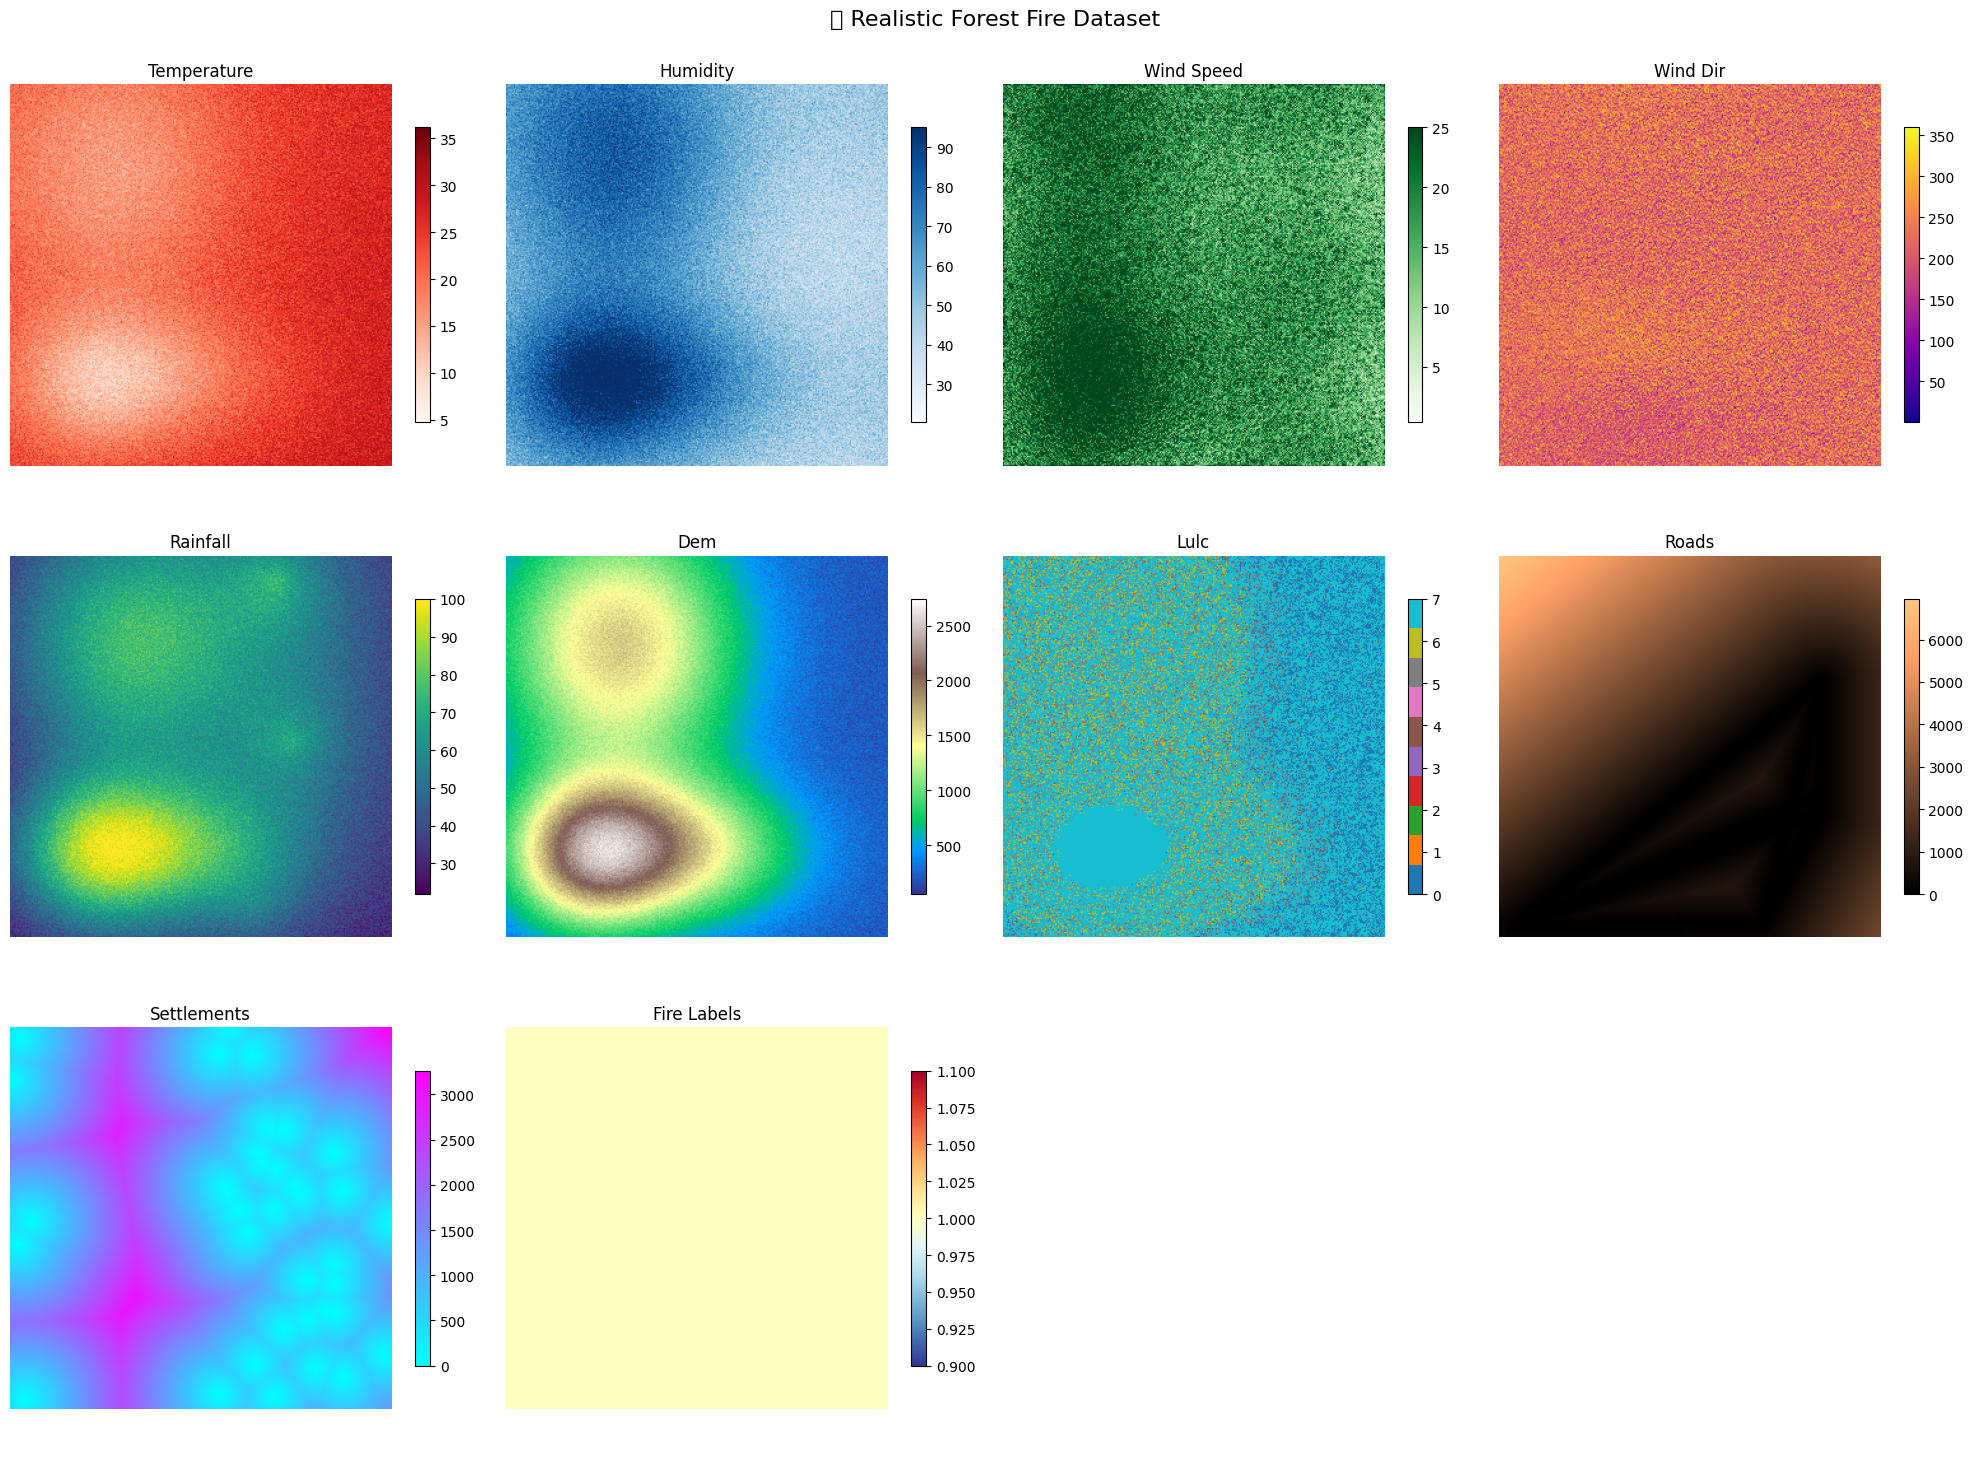

✅ Realistic dataset generation completed!


In [7]:
# Save the realistic dataset to GeoTIFF files
print("💾 Saving realistic dataset to GeoTIFF files...")

for name, data in realistic_data.items():
    filepath = f'data/{name}.tif'
    with rasterio.open(filepath, 'w', **data_profile) as dst:
        dst.write(data.astype(np.float32), 1)
    print(f"✅ Saved {name}.tif")

print("\n📊 Dataset Statistics:")
print("=" * 50)
for name, data in realistic_data.items():
    print(f"{name:12s}: min={np.min(data):8.2f}, max={np.max(data):8.2f}, mean={np.mean(data):8.2f}, std={np.std(data):8.2f}")

# Visualize the generated dataset
print("\n🎨 Visualizing generated dataset...")

fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

data_items = list(realistic_data.items())
cmaps = ['Reds', 'Blues', 'Greens', 'plasma', 'viridis', 'terrain', 'tab10', 'copper', 'cool', 'RdYlBu_r']

for i, (name, data) in enumerate(data_items):
    if i < len(axes):
        ax = axes[i]
        im = ax.imshow(data, cmap=cmaps[i % len(cmaps)])
        ax.set_title(f'{name.replace("_", " ").title()}')
        ax.axis('off')
        plt.colorbar(im, ax=ax, shrink=0.6)

# Hide unused subplots
for i in range(len(data_items), len(axes)):
    axes[i].axis('off')

plt.suptitle('🔥 Realistic Forest Fire Dataset', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

print("✅ Realistic dataset generation completed!")

🔬 Running dataset quality analysis...
🔍 DATASET QUALITY ANALYSIS

📈 Correlation Matrix:


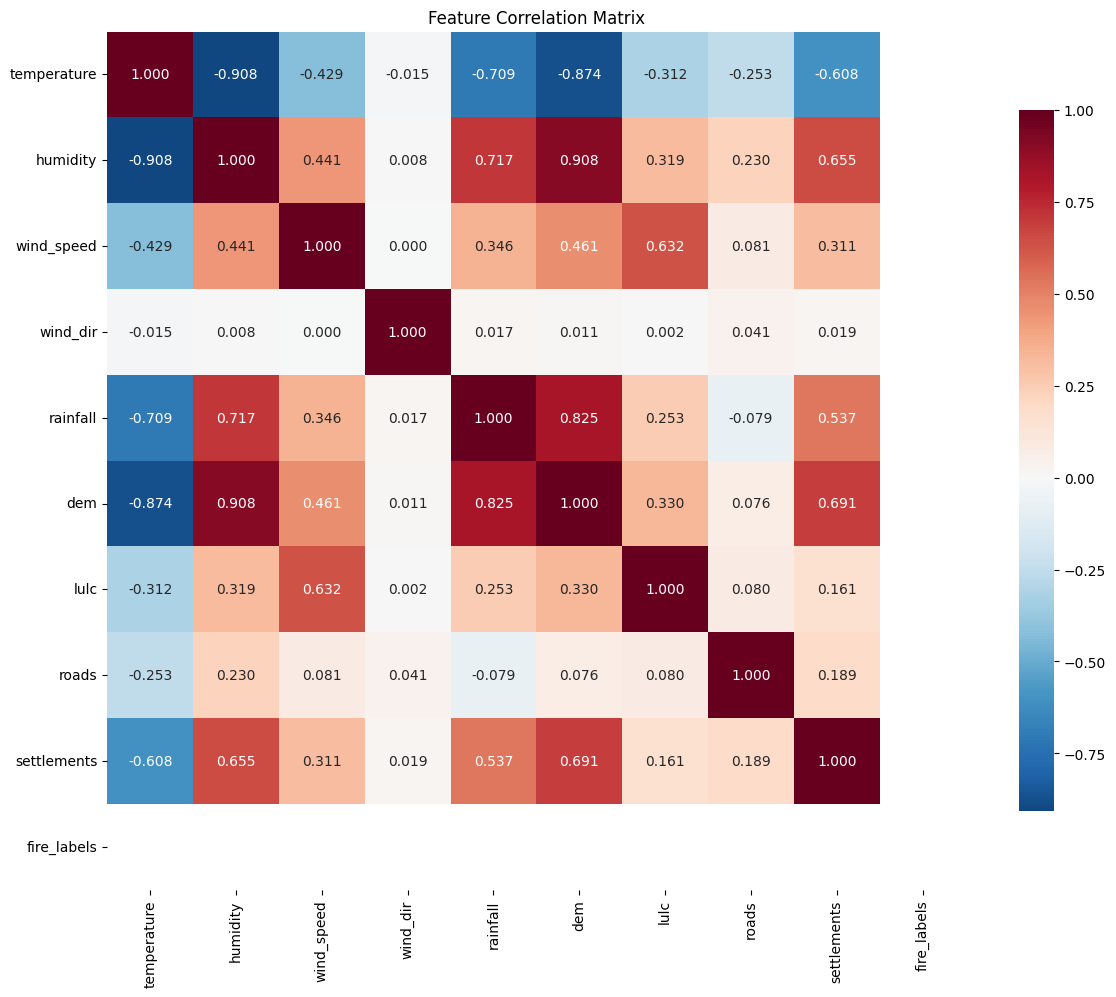


🔥 Fire Risk Analysis:
Total pixels: 90,000
Fire pixels: 90,000 (100.00%)
No-fire pixels: 0 (0.00%)

📊 Fire vs No-Fire Conditions:


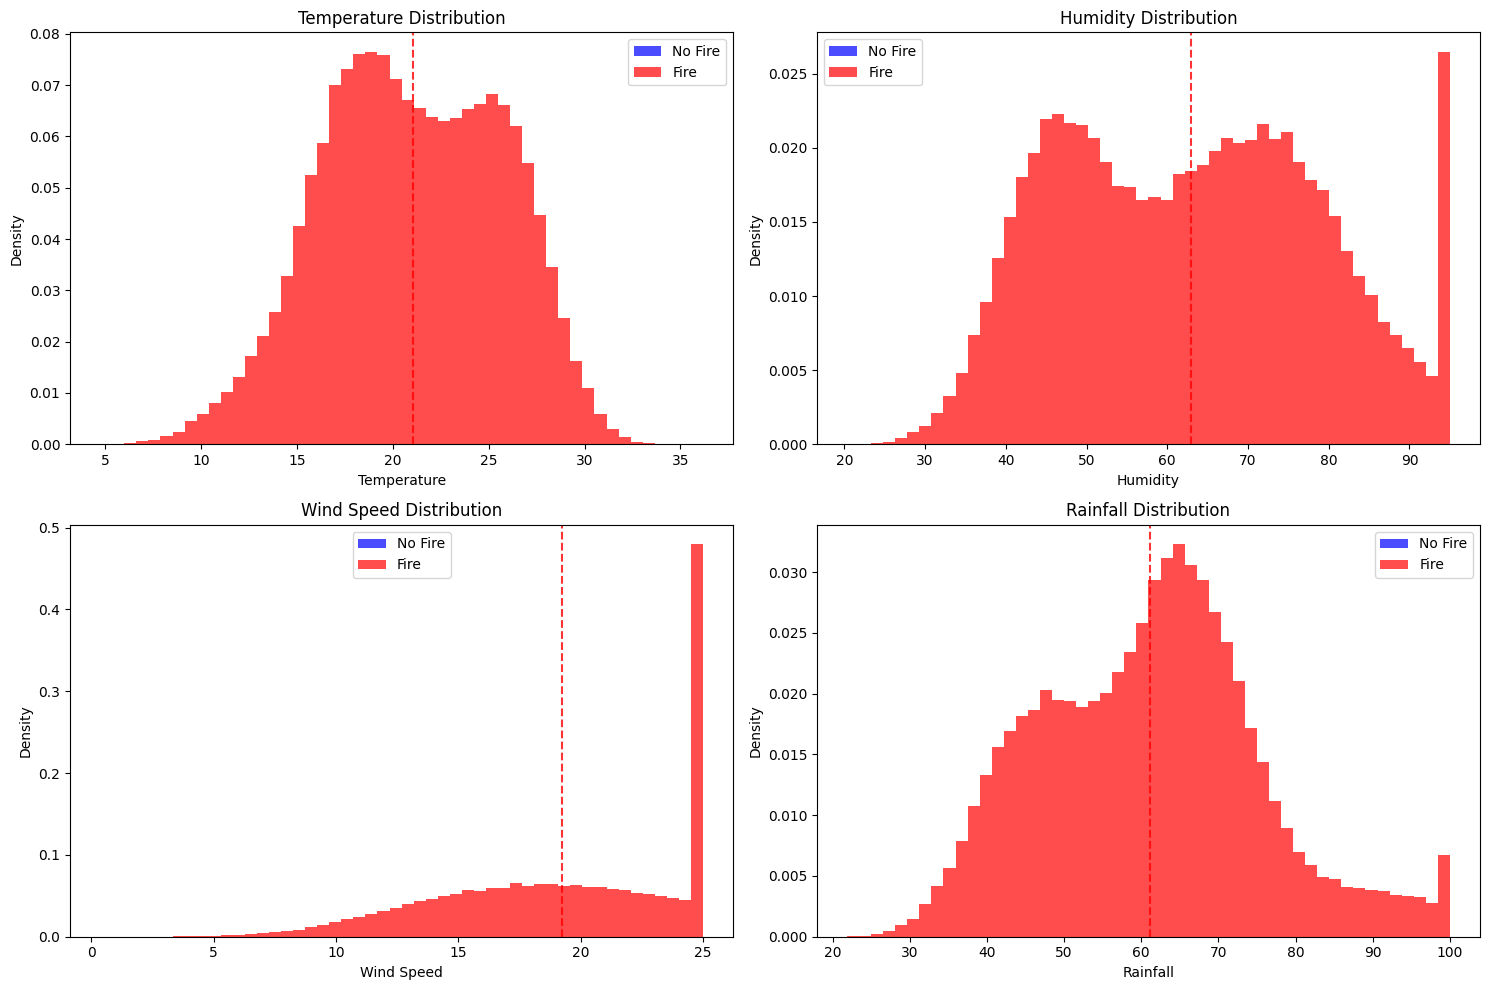


🗺️ Spatial Fire Distribution:


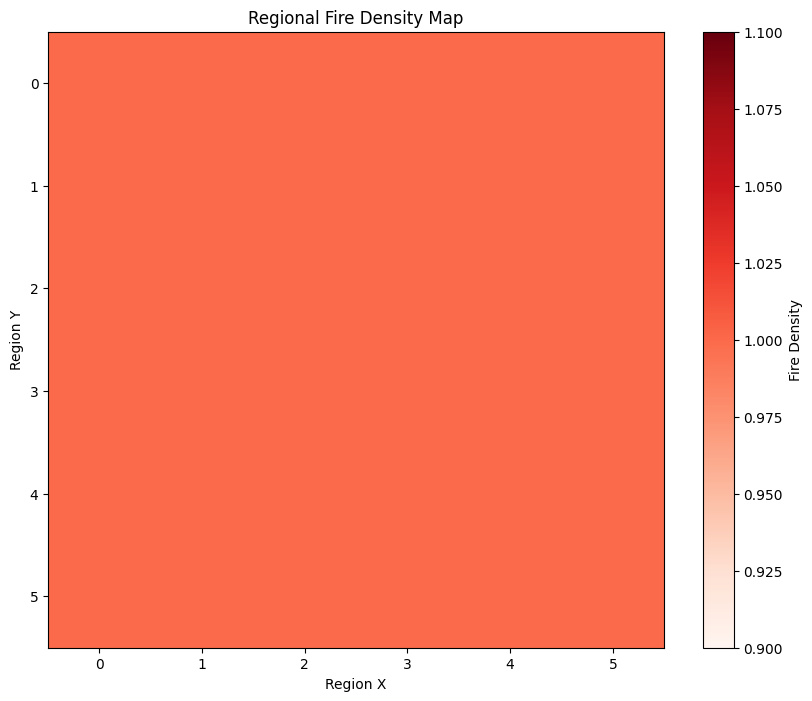


🌡️ Environmental Conditions Summary:
       Feature  Fire_Mean  No_Fire_Mean  Difference
0  temperature     21.033           NaN         NaN
1     humidity     62.932           NaN         NaN
2   wind_speed     19.258           NaN         NaN
3     rainfall     61.135           NaN         NaN

✅ Dataset quality analysis completed!
📁 Analysis results saved to output/ directory


In [8]:
def analyze_dataset_quality(data_dict):
    """
    Analyze the quality and relationships in the generated dataset
    """
    print("🔍 DATASET QUALITY ANALYSIS")
    print("=" * 60)
    
    # Convert to DataFrame for correlation analysis
    data_flat = {}
    for name, data in data_dict.items():
        data_flat[name] = data.flatten()
    
    df = pd.DataFrame(data_flat)
    
    # 1. Correlation Analysis
    print("\n📈 Correlation Matrix:")
    correlation_matrix = df.corr()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0, 
                square=True, fmt='.3f', cbar_kws={"shrink": .8})
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    # 2. Fire Risk Analysis
    print("\n🔥 Fire Risk Analysis:")
    fire_pixels = df[df['fire_labels'] == 1]
    no_fire_pixels = df[df['fire_labels'] == 0]
    
    print(f"Total pixels: {len(df):,}")
    print(f"Fire pixels: {len(fire_pixels):,} ({len(fire_pixels)/len(df)*100:.2f}%)")
    print(f"No-fire pixels: {len(no_fire_pixels):,} ({len(no_fire_pixels)/len(df)*100:.2f}%)")
    
    # Compare fire vs no-fire conditions
    print("\n📊 Fire vs No-Fire Conditions:")
    features_to_compare = ['temperature', 'humidity', 'wind_speed', 'rainfall']
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, feature in enumerate(features_to_compare):
        ax = axes[i]
        
        # Create histograms
        ax.hist(no_fire_pixels[feature], bins=50, alpha=0.7, label='No Fire', color='blue', density=True)
        ax.hist(fire_pixels[feature], bins=50, alpha=0.7, label='Fire', color='red', density=True)
        
        ax.set_xlabel(feature.replace('_', ' ').title())
        ax.set_ylabel('Density')
        ax.legend()
        ax.set_title(f'{feature.replace("_", " ").title()} Distribution')
        
        # Add statistics
        fire_mean = fire_pixels[feature].mean()
        no_fire_mean = no_fire_pixels[feature].mean()
        ax.axvline(fire_mean, color='red', linestyle='--', alpha=0.8, label=f'Fire Mean: {fire_mean:.2f}')
        ax.axvline(no_fire_mean, color='blue', linestyle='--', alpha=0.8, label=f'No Fire Mean: {no_fire_mean:.2f}')
    
    plt.tight_layout()
    plt.show()
    
    # 3. Spatial Analysis
    print("\n🗺️ Spatial Fire Distribution:")
    fire_raster = data_dict['fire_labels']
    
    # Calculate fire density in different regions
    h, w = fire_raster.shape
    region_size = 50
    
    fire_density_map = np.zeros((h//region_size, w//region_size))
    
    for i in range(0, h, region_size):
        for j in range(0, w, region_size):
            region = fire_raster[i:i+region_size, j:j+region_size]
            fire_density_map[i//region_size, j//region_size] = np.mean(region)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(fire_density_map, cmap='Reds', interpolation='nearest')
    plt.colorbar(label='Fire Density')
    plt.title('Regional Fire Density Map')
    plt.xlabel('Region X')
    plt.ylabel('Region Y')
    plt.show()
    
    # 4. Environmental Conditions Summary
    print("\n🌡️ Environmental Conditions Summary:")
    conditions_summary = pd.DataFrame({
        'Feature': features_to_compare,
        'Fire_Mean': [fire_pixels[f].mean() for f in features_to_compare],
        'No_Fire_Mean': [no_fire_pixels[f].mean() for f in features_to_compare],
        'Difference': [fire_pixels[f].mean() - no_fire_pixels[f].mean() for f in features_to_compare]
    })
    
    print(conditions_summary.round(3))
    
    return correlation_matrix, conditions_summary

# Run dataset quality analysis
print("🔬 Running dataset quality analysis...")
correlation_matrix, conditions_summary = analyze_dataset_quality(realistic_data)

# Save analysis results
correlation_matrix.to_csv('output/correlation_matrix.csv')
conditions_summary.to_csv('output/fire_conditions_summary.csv', index=False)

print("\n✅ Dataset quality analysis completed!")
print("📁 Analysis results saved to output/ directory")

🎭 Creating custom fire scenarios...
🎭 GENERATING CUSTOM FIRE SCENARIOS

🎯 Generating drought_scenario: Severe drought conditions with low rainfall
Generating 200x200 realistic dataset with 10 fire events...
Generating realistic terrain...
Generating temperature data...
Generating humidity data...
Generating wind data...
Generating wind direction...
Generating rainfall data...
Generating land use/land cover...
Generating road network...
Generating settlement proximity...
Generating fire occurrence labels...
   💥 Fire pixels: 3933 (9.83%)

🎯 Generating windy_scenario: High wind conditions promoting fire spread
Generating 200x200 realistic dataset with 10 fire events...
Generating realistic terrain...
Generating temperature data...
Generating humidity data...
Generating wind data...
Generating wind direction...
Generating rainfall data...
Generating land use/land cover...
Generating road network...
Generating settlement proximity...
Generating fire occurrence labels...
   💥 Fire pixels: 1

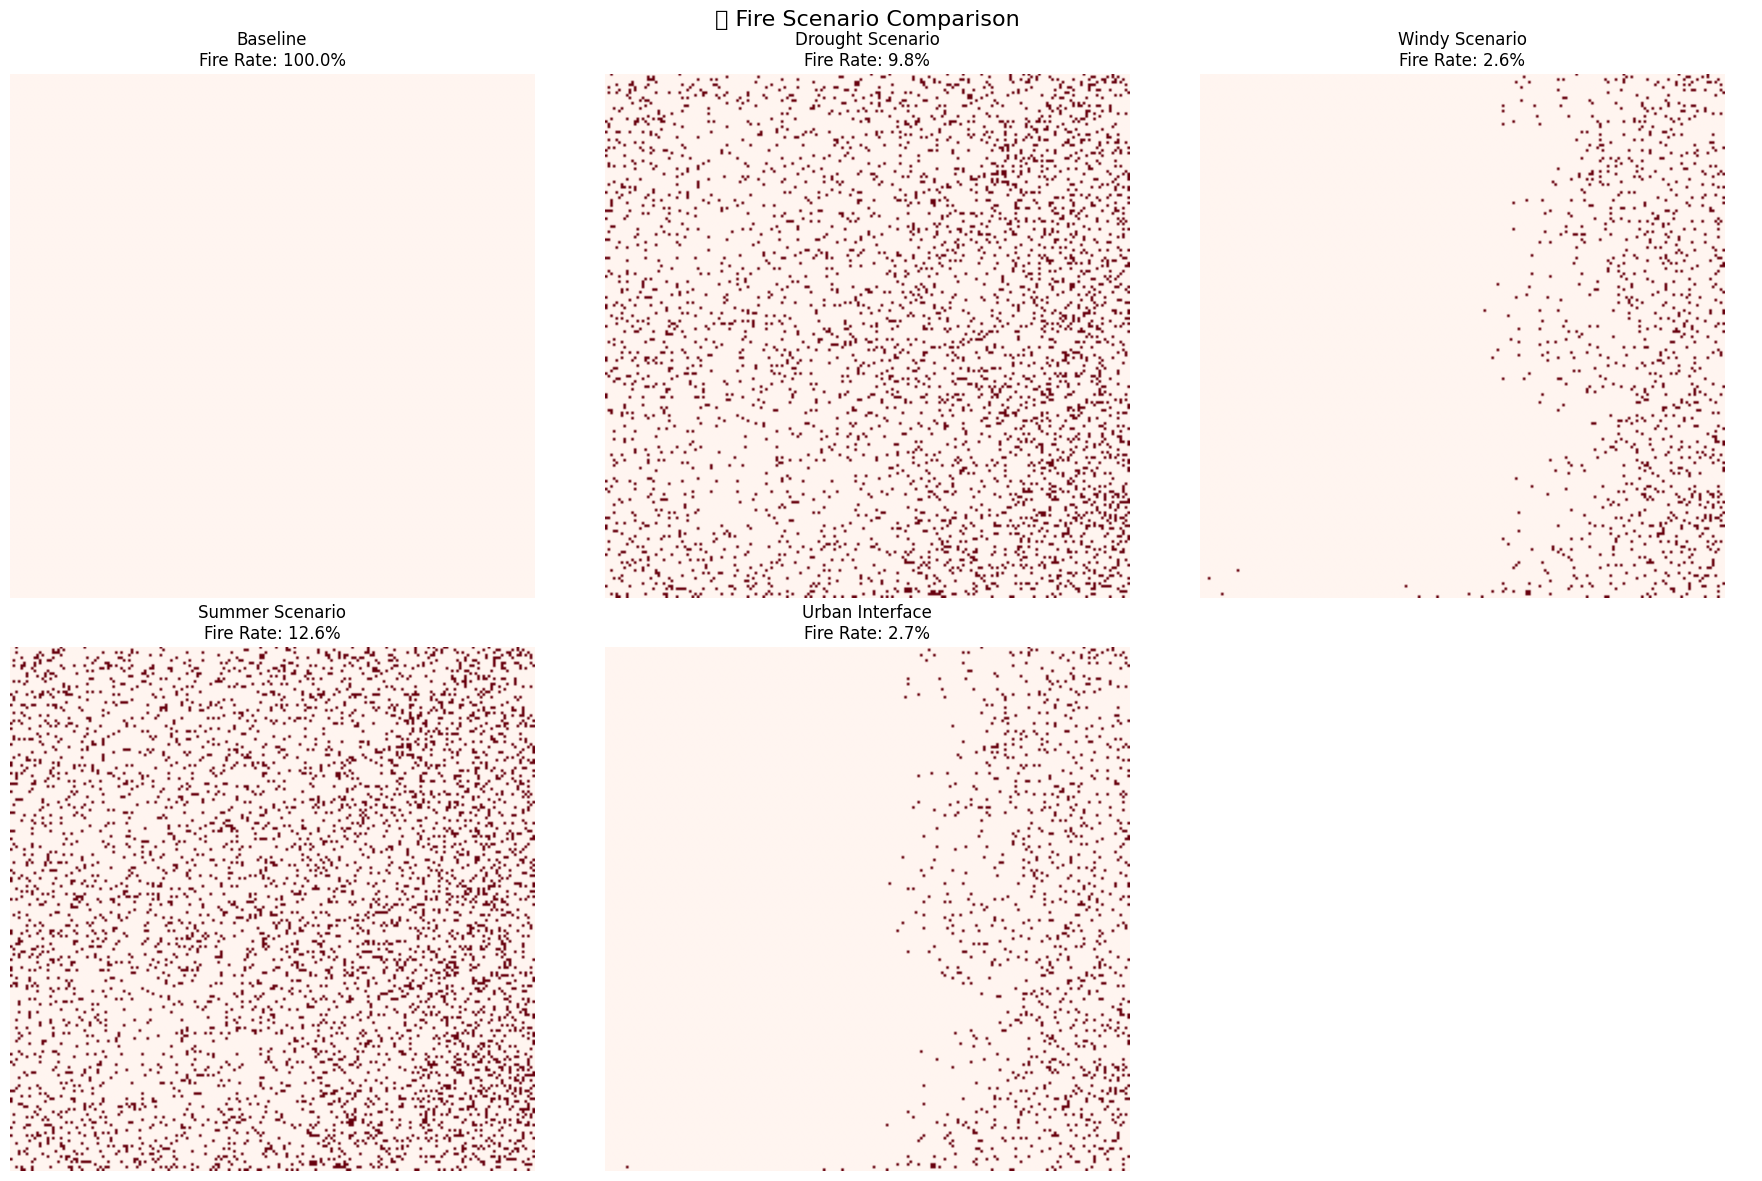

✅ Custom scenarios generated successfully!
📁 Scenario datasets saved in data/scenarios/ directory


In [9]:
def generate_custom_scenarios():
    """
    Generate different fire scenarios for testing model robustness
    """
    print("🎭 GENERATING CUSTOM FIRE SCENARIOS")
    print("=" * 50)
    
    scenarios = {
        'drought_scenario': {
            'description': 'Severe drought conditions with low rainfall',
            'params': {
                'rainfall_factor': 0.3,
                'temperature_boost': 5,
                'humidity_drop': 15
            }
        },
        'windy_scenario': {
            'description': 'High wind conditions promoting fire spread',
            'params': {
                'wind_speed_factor': 2.0,
                'wind_variability': 0.5
            }
        },
        'summer_scenario': {
            'description': 'Peak summer fire season conditions',
            'params': {
                'temperature_boost': 8,
                'humidity_drop': 20,
                'rainfall_factor': 0.2
            }
        },
        'urban_interface': {
            'description': 'Urban-wildland interface with high human activity',
            'params': {
                'urban_density': 3.0,
                'road_density': 2.0,
                'human_ignition_factor': 2.0
            }
        }
    }
    
    scenario_datasets = {}
    
    for scenario_name, scenario_info in scenarios.items():
        print(f"\n🎯 Generating {scenario_name}: {scenario_info['description']}")
        
        # Generate base dataset
        base_data, profile = generate_realistic_dataset(
            height=200, width=200, num_fire_events=10, seed=42
        )
        
        # Apply scenario modifications
        modified_data = base_data.copy()
        params = scenario_info['params']
        
        # Temperature modifications
        if 'temperature_boost' in params:
            modified_data['temperature'] += params['temperature_boost']
        
        # Humidity modifications
        if 'humidity_drop' in params:
            modified_data['humidity'] -= params['humidity_drop']
            modified_data['humidity'] = np.clip(modified_data['humidity'], 10, 95)
        
        # Rainfall modifications
        if 'rainfall_factor' in params:
            modified_data['rainfall'] *= params['rainfall_factor']
        
        # Wind modifications
        if 'wind_speed_factor' in params:
            modified_data['wind_speed'] *= params['wind_speed_factor']
            modified_data['wind_speed'] = np.clip(modified_data['wind_speed'], 0, 40)
        
        # Urban/road density modifications
        if 'urban_density' in params:
            # Increase urban areas
            urban_mask = modified_data['lulc'] == 2
            urban_expanded = ndimage.binary_dilation(urban_mask, iterations=int(params['urban_density']))
            modified_data['lulc'][urban_expanded] = 2
        
        if 'road_density' in params:
            # Decrease road distances (more roads)
            modified_data['roads'] /= params['road_density']
        
        # Recalculate fire risk for modified scenario
        fire_risk = np.zeros_like(modified_data['temperature'])
        
        # Temperature effect
        fire_risk += (modified_data['temperature'] - 15) / 30 * 0.3
        
        # Humidity effect
        fire_risk += (80 - modified_data['humidity']) / 70 * 0.2
        
        # Wind effect
        fire_risk += modified_data['wind_speed'] / 25 * 0.1
        
        # Drought effect
        fire_risk += (30 - modified_data['rainfall']) / 30 * 0.2
        
        # Human activity effect
        if 'human_ignition_factor' in params:
            human_risk = np.exp(-modified_data['roads'] / 1000) * 0.05 * params['human_ignition_factor']
            fire_risk += human_risk
        
        # Generate new fire labels based on modified risk
        fire_labels = np.zeros_like(fire_risk)
        fire_probability = np.clip(fire_risk, 0, 1)
        
        # Add some fire events based on probability
        random_fire = np.random.random(fire_risk.shape)
        fire_labels = (random_fire < fire_probability * 0.3).astype(float)
        
        # Ensure minimum fire coverage
        if fire_labels.sum() < 100:
            top_risk_indices = np.unravel_index(np.argsort(fire_risk.ravel())[-200:], fire_risk.shape)
            fire_labels[top_risk_indices] = 1
        
        modified_data['fire_labels'] = fire_labels
        scenario_datasets[scenario_name] = modified_data
        
        # Save scenario dataset
        scenario_dir = f'data/scenarios/{scenario_name}'
        os.makedirs(scenario_dir, exist_ok=True)
        
        for data_name, data_array in modified_data.items():
            filepath = f'{scenario_dir}/{data_name}.tif'
            with rasterio.open(filepath, 'w', **profile) as dst:
                dst.write(data_array.astype(np.float32), 1)
        
        fire_count = modified_data['fire_labels'].sum()
        fire_percentage = fire_count / modified_data['fire_labels'].size * 100
        print(f"   💥 Fire pixels: {fire_count:.0f} ({fire_percentage:.2f}%)")
    
    return scenario_datasets

# Generate custom scenarios
print("🎭 Creating custom fire scenarios...")
scenario_datasets = generate_custom_scenarios()

# Visualize scenarios comparison
print("\n📊 Comparing fire scenarios...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Plot baseline first
base_data = realistic_data['fire_labels']
axes[0].imshow(base_data, cmap='Reds')
axes[0].set_title(f'Baseline\nFire Rate: {base_data.mean()*100:.1f}%')
axes[0].axis('off')

# Plot scenarios
for i, (scenario_name, scenario_data) in enumerate(scenario_datasets.items(), 1):
    if i < len(axes):
        fire_data = scenario_data['fire_labels']
        axes[i].imshow(fire_data, cmap='Reds')
        axes[i].set_title(f'{scenario_name.replace("_", " ").title()}\nFire Rate: {fire_data.mean()*100:.1f}%')
        axes[i].axis('off')

# Hide unused subplot
if len(scenario_datasets) + 1 < len(axes):
    axes[-1].axis('off')

plt.suptitle('🔥 Fire Scenario Comparison', fontsize=16)
plt.tight_layout()
plt.show()

print("✅ Custom scenarios generated successfully!")
print("📁 Scenario datasets saved in data/scenarios/ directory")

Loading and preprocessing raster data...
Loaded temperature: (300, 300)
Loaded humidity: (300, 300)
Loaded wind_speed: (300, 300)
Loaded wind_dir: (300, 300)
Loaded rainfall: (300, 300)
Loaded dem: (300, 300)
Loaded lulc: (300, 300)
Loaded roads: (300, 300)
Loaded settlements: (300, 300)
Loaded fire_labels: (300, 300)
Visualizing key features...


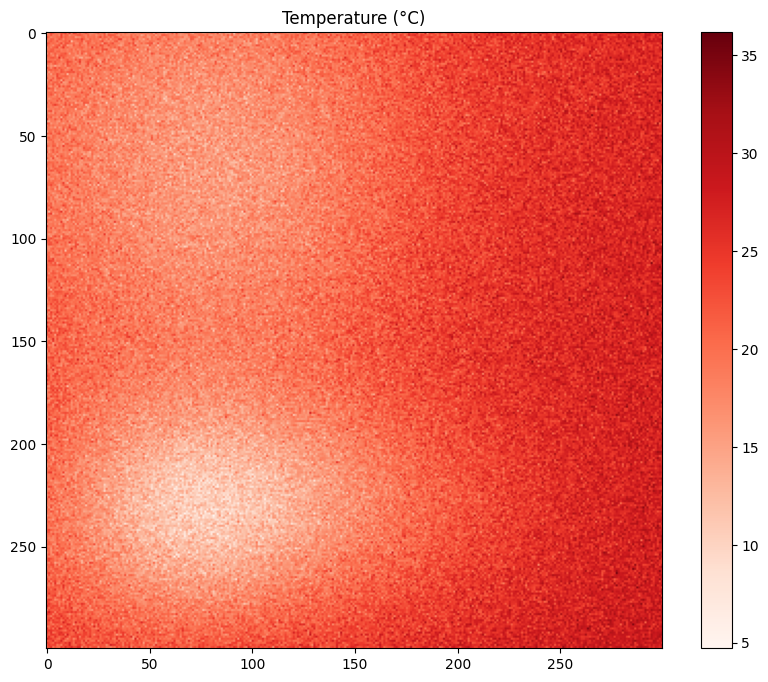

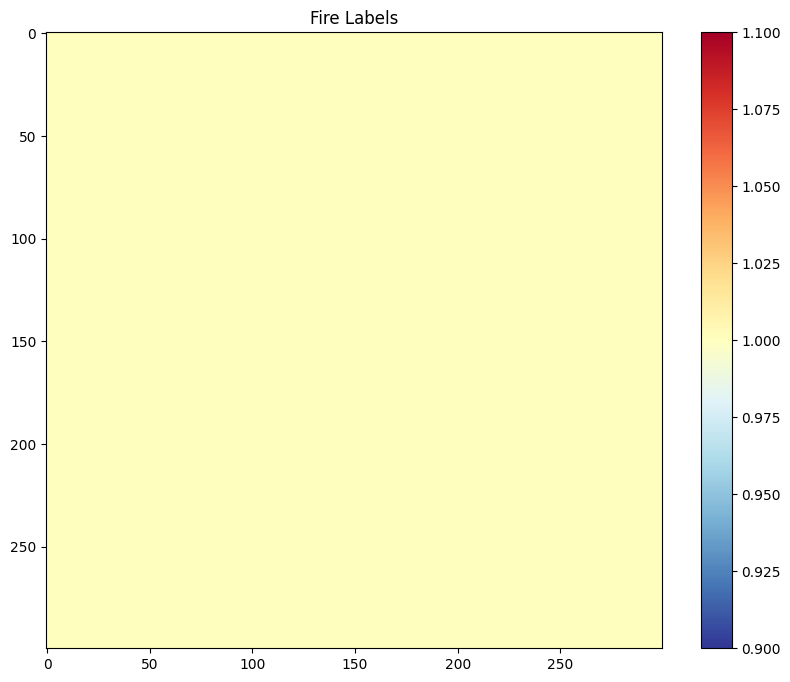

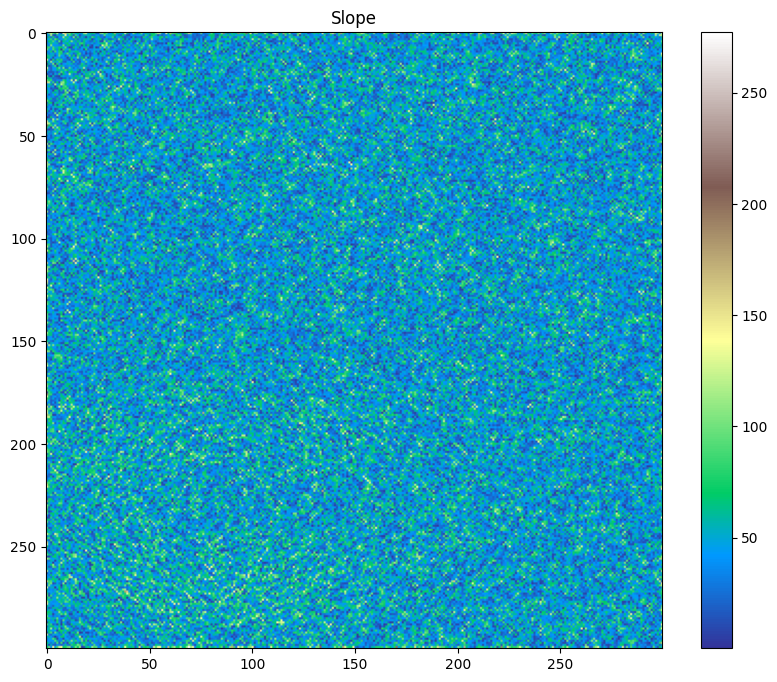

Feature stack shape: (300, 300, 11)
Labels shape: (300, 300)
Feature names: ['temperature', 'humidity', 'wind_speed', 'wind_dir', 'rainfall', 'dem', 'lulc', 'roads', 'settlements', 'slope', 'aspect']


In [10]:
def preprocess_and_stack_features():
    """Load all raster files and stack them into feature array"""
    
    print("Loading and preprocessing raster data...")
    
    features = {}
    common_shape = None
    common_transform = None
    common_profile = None
    
    for name, filepath in processor.raster_files.items():
        data, transform, crs, profile = processor.load_raster(filepath)
        
        if data is not None:
            if common_shape is None:
                common_shape = data.shape
                common_transform = transform
                common_profile = profile
            
            resampled_data, _, _ = processor.resample_raster(
                data, transform, profile, processor.target_resolution
            )
            
            if resampled_data.shape != common_shape:
                resampled_data = np.resize(resampled_data, common_shape)
            
            features[name] = resampled_data
            print(f"Loaded {name}: {resampled_data.shape}")
    
    dem = features['dem']
    slope, aspect = processor.calculate_slope_aspect(dem)
    features['slope'] = slope
    features['aspect'] = aspect
    
    print("Visualizing key features...")
    processor.visualize_raster(features['temperature'], 'Temperature (°C)', 'Reds')
    processor.visualize_raster(features['fire_labels'], 'Fire Labels', 'RdYlBu_r')
    processor.visualize_raster(features['slope'], 'Slope', 'terrain')
    
    feature_names = [name for name in features.keys() if name != 'fire_labels']
    feature_stack = np.stack([features[name] for name in feature_names], axis=-1)
    
    labels = features['fire_labels']
    
    print(f"Feature stack shape: {feature_stack.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Feature names: {feature_names}")
    
    return feature_stack, labels, feature_names, common_transform, common_profile

feature_stack, labels, feature_names, transform, profile = preprocess_and_stack_features()

In [11]:
class FirePredictionModel:
    def __init__(self, model_path=None):
        self.model = None
        self.feature_names = None
        self.model_path = model_path or MODEL_PATH
        
    def prepare_data(self, feature_stack, labels):
        """Prepare data for training"""
        height, width, n_features = feature_stack.shape
        
        X = feature_stack.reshape(-1, n_features)
        y = labels.reshape(-1)
        
        valid_mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y)
        X = X[valid_mask]
        y = y[valid_mask]
        
        return X, y
    
    def train_model(self, X, y):
        """Train RandomForest model"""
        print("🔄 Training RandomForest model...")
        print(f"   Training samples: {len(X):,}")
        print(f"   Features: {X.shape[1]}")
        
        self.model = RandomForestClassifier(
            n_estimators=100,
            max_depth=15,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42,
            n_jobs=-1
        )
        
        self.model.fit(X, y)
        
        joblib.dump(self.model, self.model_path)
        print(f"✅ Model trained and saved to {self.model_path}")
        
    def load_model(self):
        """Load pre-trained model"""
        if os.path.exists(self.model_path):
            self.model = joblib.load(self.model_path)
            print(f"✅ Model loaded from {self.model_path}")
            return True
        else:
            print(f"❌ No model found at {self.model_path}")
            return False
    
    def predict(self, X):
        """Make predictions"""
        if self.model is None:
            raise ValueError("Model not trained or loaded")
        
        return self.model.predict(X)
    
    def predict_proba(self, X):
        """Get prediction probabilities"""
        if self.model is None:
            raise ValueError("Model not trained or loaded")
        
        return self.model.predict_proba(X)
    
    def get_feature_importance(self):
        """Get feature importance"""
        if self.model is None:
            raise ValueError("Model not trained or loaded")
        
        return self.model.feature_importances_

fire_model = FirePredictionModel()
print("FirePredictionModel created successfully!")

FirePredictionModel created successfully!


📊 Training data prepared: X=(90000, 11), y=(90000,)

🤖 MODEL TRAINING/LOADING:
📂 Attempting to load existing model...
✅ Model loaded from models/fire_prediction_model.pkl
✅ Existing model loaded successfully!

🔮 Making predictions...
Visualizing predictions...


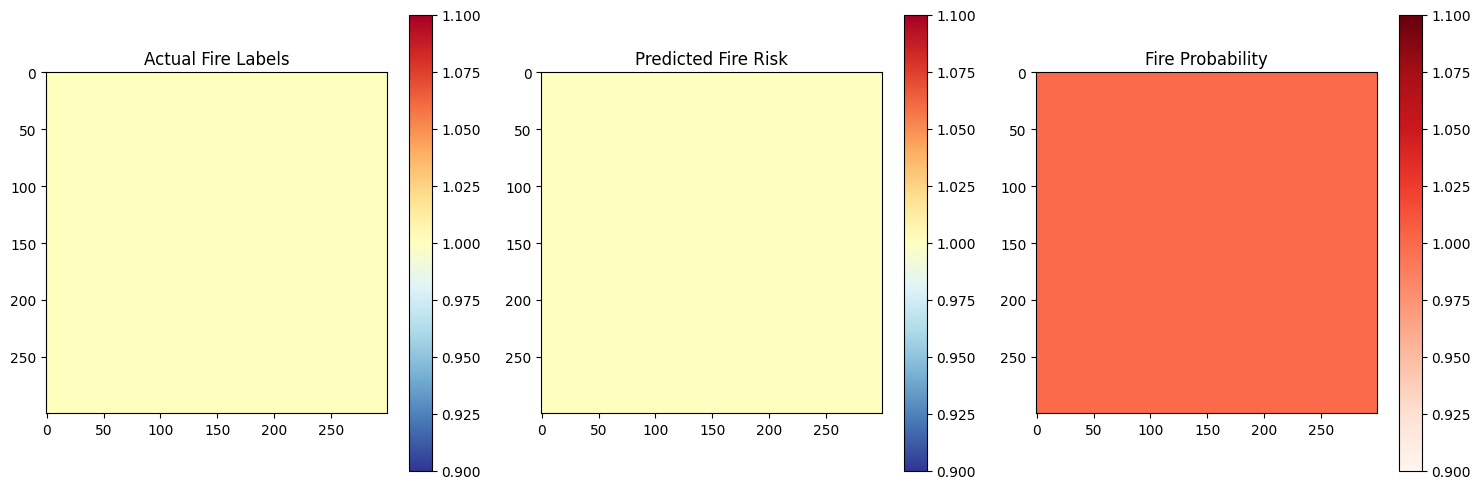

Saving prediction maps...
Prediction maps saved successfully!


In [12]:
X, y = fire_model.prepare_data(feature_stack, labels)
print(f"📊 Training data prepared: X={X.shape}, y={y.shape}")

# Simple model training logic based on user choice
print("\n🤖 MODEL TRAINING/LOADING:")
print("=" * 40)

if RETRAIN_MODEL:
    print("🔄 Training new model as requested...")
    fire_model.train_model(X, y)
else:
    print("📂 Attempting to load existing model...")
    if fire_model.load_model():
        print("✅ Existing model loaded successfully!")
    else:
        print("⚠️  No existing model found - training new model...")
        fire_model.train_model(X, y)

print("\n🔮 Making predictions...")
predictions = fire_model.predict(X)
probabilities = fire_model.predict_proba(X)

height, width = labels.shape
prediction_map = np.full((height * width,), np.nan)

valid_mask = ~np.isnan(feature_stack.reshape(-1, feature_stack.shape[-1])).any(axis=1) & ~np.isnan(labels.reshape(-1))
prediction_map[valid_mask] = predictions

prediction_map = prediction_map.reshape(height, width)

fire_probability_map = np.full((height * width,), np.nan)
fire_probability_map[valid_mask] = probabilities.ravel()
fire_probability_map = fire_probability_map.reshape(height, width)

print("Visualizing predictions...")
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(labels, cmap='RdYlBu_r')
plt.title('Actual Fire Labels')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(prediction_map, cmap='RdYlBu_r')
plt.title('Predicted Fire Risk')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(fire_probability_map, cmap='Reds')
plt.title('Fire Probability')
plt.colorbar()

plt.tight_layout()
plt.show()

print("Saving prediction maps...")
with rasterio.open('output/fire_prediction.tif', 'w', **profile) as dst:
    dst.write(prediction_map.astype(np.float32), 1)

with rasterio.open('output/fire_probability.tif', 'w', **profile) as dst:
    dst.write(fire_probability_map.astype(np.float32), 1)

print("Prediction maps saved successfully!")

Simulating fire spread...
Visualizing fire spread simulation...


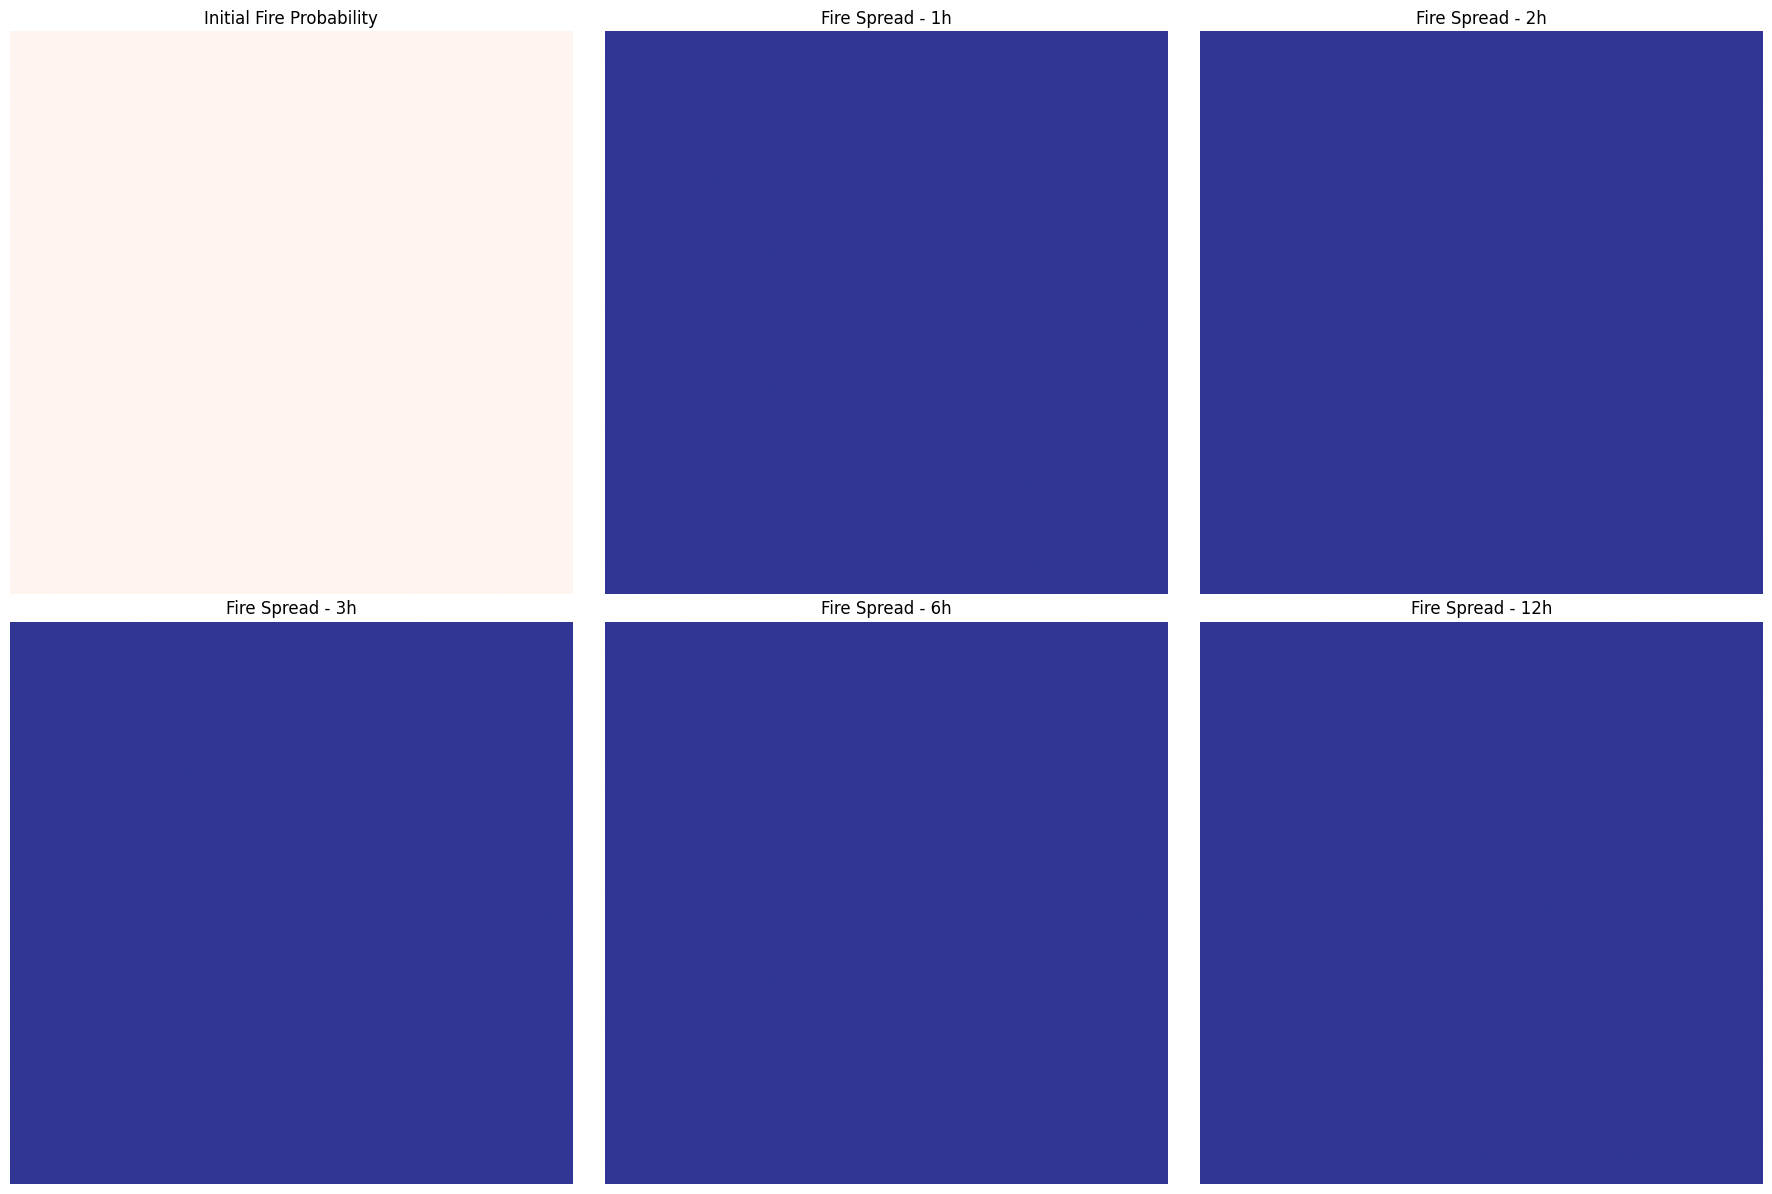

Saving fire spread maps...
Fire spread simulation completed!


In [13]:
class FireSpreadSimulator:
    def __init__(self, fire_probability_map, wind_speed, wind_dir, fuel_load, slope):
        self.fire_prob = fire_probability_map
        self.wind_speed = wind_speed
        self.wind_dir = wind_dir
        self.fuel_load = fuel_load
        self.slope = slope
        self.height, self.width = fire_probability_map.shape
        
        self.fire_state = np.zeros_like(fire_probability_map)
        self.burned_state = np.zeros_like(fire_probability_map)
        
        high_risk_threshold = 0.7
        self.fire_state[fire_probability_map > high_risk_threshold] = 1
        
    def calculate_spread_probability(self, i, j):
        """Calculate fire spread probability based on environmental factors"""
        base_prob = 0.3
        
        wind_factor = min(self.wind_speed[i, j] / 20.0, 1.0)
        fuel_factor = min(self.fuel_load[i, j] / 10.0, 1.0)
        slope_factor = min(self.slope[i, j] / 45.0, 1.0) * 0.5
        
        spread_prob = base_prob + (wind_factor * 0.4) + (fuel_factor * 0.2) + (slope_factor * 0.1)
        
        return min(spread_prob, 1.0)
    
    def get_neighbors(self, i, j):
        """Get valid neighboring cells"""
        neighbors = []
        for di in [-1, 0, 1]:
            for dj in [-1, 0, 1]:
                if di == 0 and dj == 0:
                    continue
                ni, nj = i + di, j + dj
                if 0 <= ni < self.height and 0 <= nj < self.width:
                    neighbors.append((ni, nj))
        return neighbors
    
    def simulate_step(self):
        """Simulate one time step of fire spread"""
        new_fire_state = self.fire_state.copy()
        
        fire_cells = np.where(self.fire_state == 1)
        
        for i, j in zip(fire_cells[0], fire_cells[1]):
            if self.burned_state[i, j] == 1:
                continue
            
            spread_prob = self.calculate_spread_probability(i, j)
            
            for ni, nj in self.get_neighbors(i, j):
                if (self.fire_state[ni, nj] == 0 and 
                    self.burned_state[ni, nj] == 0 and
                    np.random.random() < spread_prob):
                    new_fire_state[ni, nj] = 1
            
            self.burned_state[i, j] = 1
            new_fire_state[i, j] = 0
        
        self.fire_state = new_fire_state
        
        return self.fire_state + self.burned_state * 0.5
    
    def simulate_spread(self, hours):
        """Simulate fire spread for given number of hours"""
        spread_maps = {}
        
        for hour in [1, 2, 3, 6, 12]:
            if hour > hours:
                break
            
            current_state = self.fire_state.copy()
            current_burned = self.burned_state.copy()
            
            for step in range(hour * 6):
                self.simulate_step()
            
            spread_maps[f'{hour}h'] = self.fire_state + self.burned_state * 0.5
            
            self.fire_state = current_state
            self.burned_state = current_burned
        
        return spread_maps

simulator = FireSpreadSimulator(
    fire_probability_map,
    feature_stack[:, :, feature_names.index('wind_speed')],
    feature_stack[:, :, feature_names.index('wind_dir')],
    feature_stack[:, :, feature_names.index('lulc')],
    feature_stack[:, :, feature_names.index('slope')]
)

print("Simulating fire spread...")
spread_maps = simulator.simulate_spread(12)

print("Visualizing fire spread simulation...")
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

axes[0].imshow(fire_probability_map, cmap='Reds')
axes[0].set_title('Initial Fire Probability')
axes[0].axis('off')

for idx, (time_label, spread_map) in enumerate(spread_maps.items(), 1):
    axes[idx].imshow(spread_map, cmap='RdYlBu_r')
    axes[idx].set_title(f'Fire Spread - {time_label}')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("Saving fire spread maps...")
for time_label, spread_map in spread_maps.items():
    output_path = f'output/fire_spread_{time_label}.tif'
    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(spread_map.astype(np.float32), 1)

print("Fire spread simulation completed!")

Evaluating model performance...
Model Evaluation Results:
------------------------------
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000
------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

     No Fire       0.00      0.00      0.00         0
        Fire       1.00      1.00      1.00     90000

    accuracy                           1.00     90000
   macro avg       0.50      0.50      0.50     90000
weighted avg       1.00      1.00      1.00     90000


Metrics saved to output/model_report.csv

Analyzing feature importance...


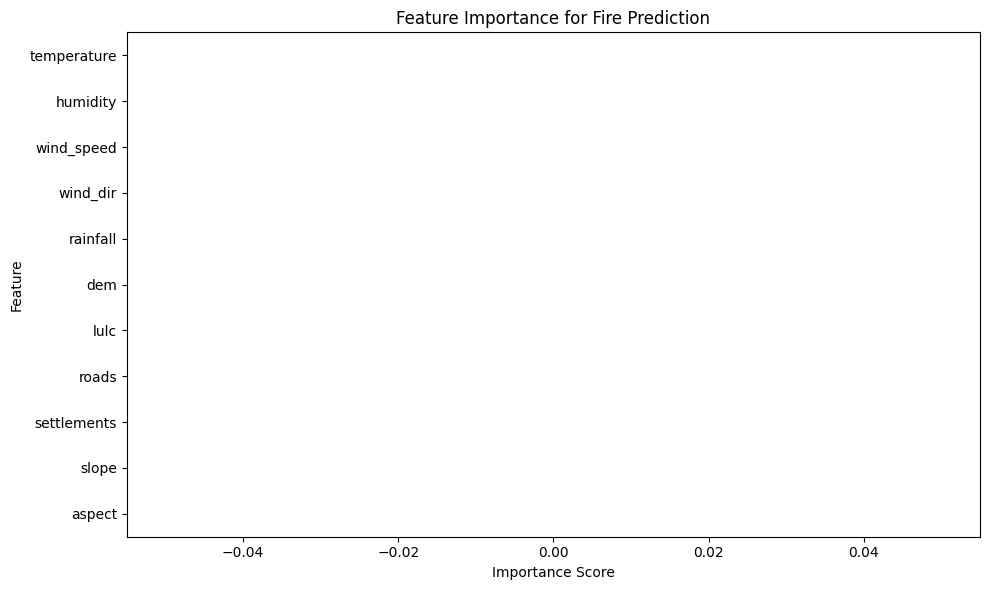


Top 5 Most Important Features:
       Feature  Importance
0  temperature         0.0
1     humidity         0.0
2   wind_speed         0.0
3     wind_dir         0.0
4     rainfall         0.0


In [14]:
def evaluate_model(y_true, y_pred):
    """Calculate comprehensive evaluation metrics"""
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')
    
    print("Model Evaluation Results:")
    print("-" * 30)
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print("-" * 30)
    
    print("\nDetailed Classification Report:")
    print(classification_report(y_true, y_pred, target_names=['No Fire', 'Fire'], labels=[0, 1]))
    
    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
        'Value': [accuracy, precision, recall, f1]
    })
    
    metrics_df.to_csv('output/model_report.csv', index=False)
    print("\nMetrics saved to output/model_report.csv")
    
    return metrics_df

def plot_feature_importance(model, feature_names):
    """Plot feature importance from the trained model"""
    
    importance = model.get_feature_importance()
    
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance_df, x='Importance', y='Feature')
    plt.title('Feature Importance for Fire Prediction')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.show()
    
    return feature_importance_df

print("Evaluating model performance...")
metrics_df = evaluate_model(y, predictions.astype(int))

print("\nAnalyzing feature importance...")
feature_importance_df = plot_feature_importance(fire_model, feature_names)

print("\nTop 5 Most Important Features:")
print(feature_importance_df.head())

Calculating statistics for key outputs...

Statistics for Fire Prediction Map:
------------------------------
Mean: 1.0000
Std: 0.0000
Min: 1.0000
Max: 1.0000
Median: 1.0000
Non-null count: 90000.0000

Statistics for Fire Probability Map:
------------------------------
Mean: 1.0000
Std: 0.0000
Min: 1.0000
Max: 1.0000
Median: 1.0000
Non-null count: 90000.0000

Visualizing model outputs...


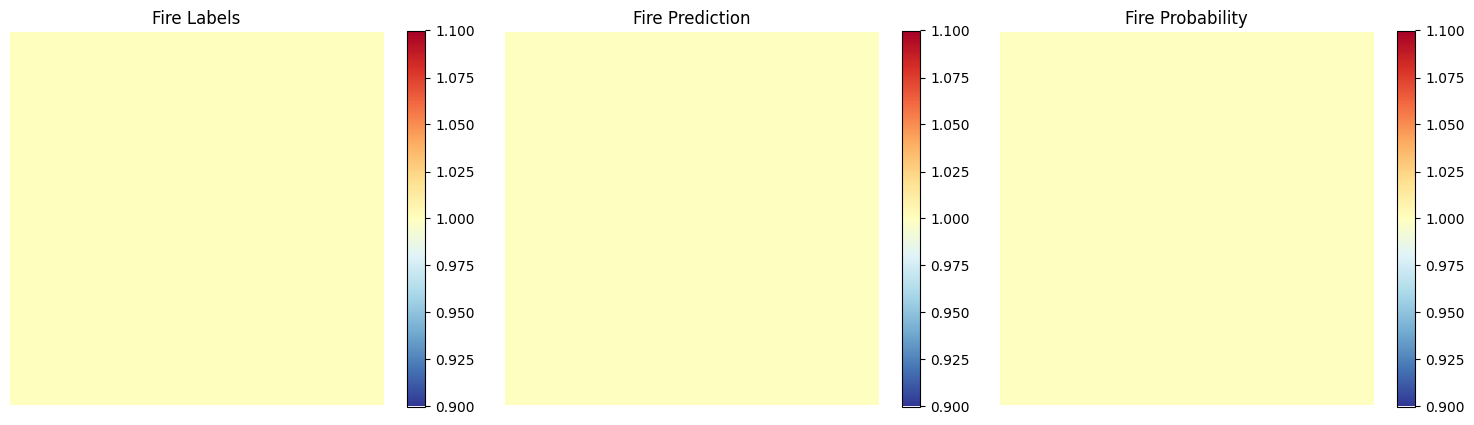

In [15]:
class RasterUtils:
    @staticmethod
    def raster_to_array(filepath):
        """Convert raster file to numpy array"""
        with rasterio.open(filepath) as src:
            array = src.read(1)
            transform = src.transform
            crs = src.crs
        return array, transform, crs
    
    @staticmethod
    def array_to_raster(array, filepath, transform, crs, dtype=np.float32):
        """Save numpy array as raster file"""
        profile = {
            'driver': 'GTiff',
            'height': array.shape[0],
            'width': array.shape[1],
            'count': 1,
            'dtype': dtype,
            'crs': crs,
            'transform': transform,
            'compress': 'lzw'
        }
        
        with rasterio.open(filepath, 'w', **profile) as dst:
            dst.write(array.astype(dtype), 1)
    
    @staticmethod
    def visualize_comparison(data_dict, titles=None, cmap='viridis', figsize=(15, 10)):
        """Visualize multiple rasters for comparison"""
        n_plots = len(data_dict)
        cols = min(3, n_plots)
        rows = (n_plots + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=figsize)
        if rows == 1:
            axes = [axes] if n_plots == 1 else axes
        else:
            axes = axes.flatten()
        
        for idx, (key, data) in enumerate(data_dict.items()):
            ax = axes[idx] if n_plots > 1 else axes
            im = ax.imshow(data, cmap=cmap)
            ax.set_title(titles[idx] if titles else key)
            ax.axis('off')
            plt.colorbar(im, ax=ax, shrink=0.8)
        
        for idx in range(n_plots, len(axes)):
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    @staticmethod
    def calculate_statistics(array, name="Array"):
        """Calculate and display array statistics"""
        stats = {
            'Mean': np.nanmean(array),
            'Std': np.nanstd(array),
            'Min': np.nanmin(array),
            'Max': np.nanmax(array),
            'Median': np.nanmedian(array),
            'Non-null count': np.sum(~np.isnan(array))
        }
        
        print(f"\nStatistics for {name}:")
        print("-" * 30)
        for key, value in stats.items():
            print(f"{key}: {value:.4f}")
        
        return stats

utils = RasterUtils()

print("Calculating statistics for key outputs...")
utils.calculate_statistics(prediction_map, "Fire Prediction Map")
utils.calculate_statistics(fire_probability_map, "Fire Probability Map")

print("\nVisualizing model outputs...")
visualization_data = {
    'Fire Labels': labels,
    'Fire Prediction': prediction_map,
    'Fire Probability': fire_probability_map
}

utils.visualize_comparison(
    visualization_data,
    cmap='RdYlBu_r',
    figsize=(15, 5)
)

Creating comprehensive visualization...


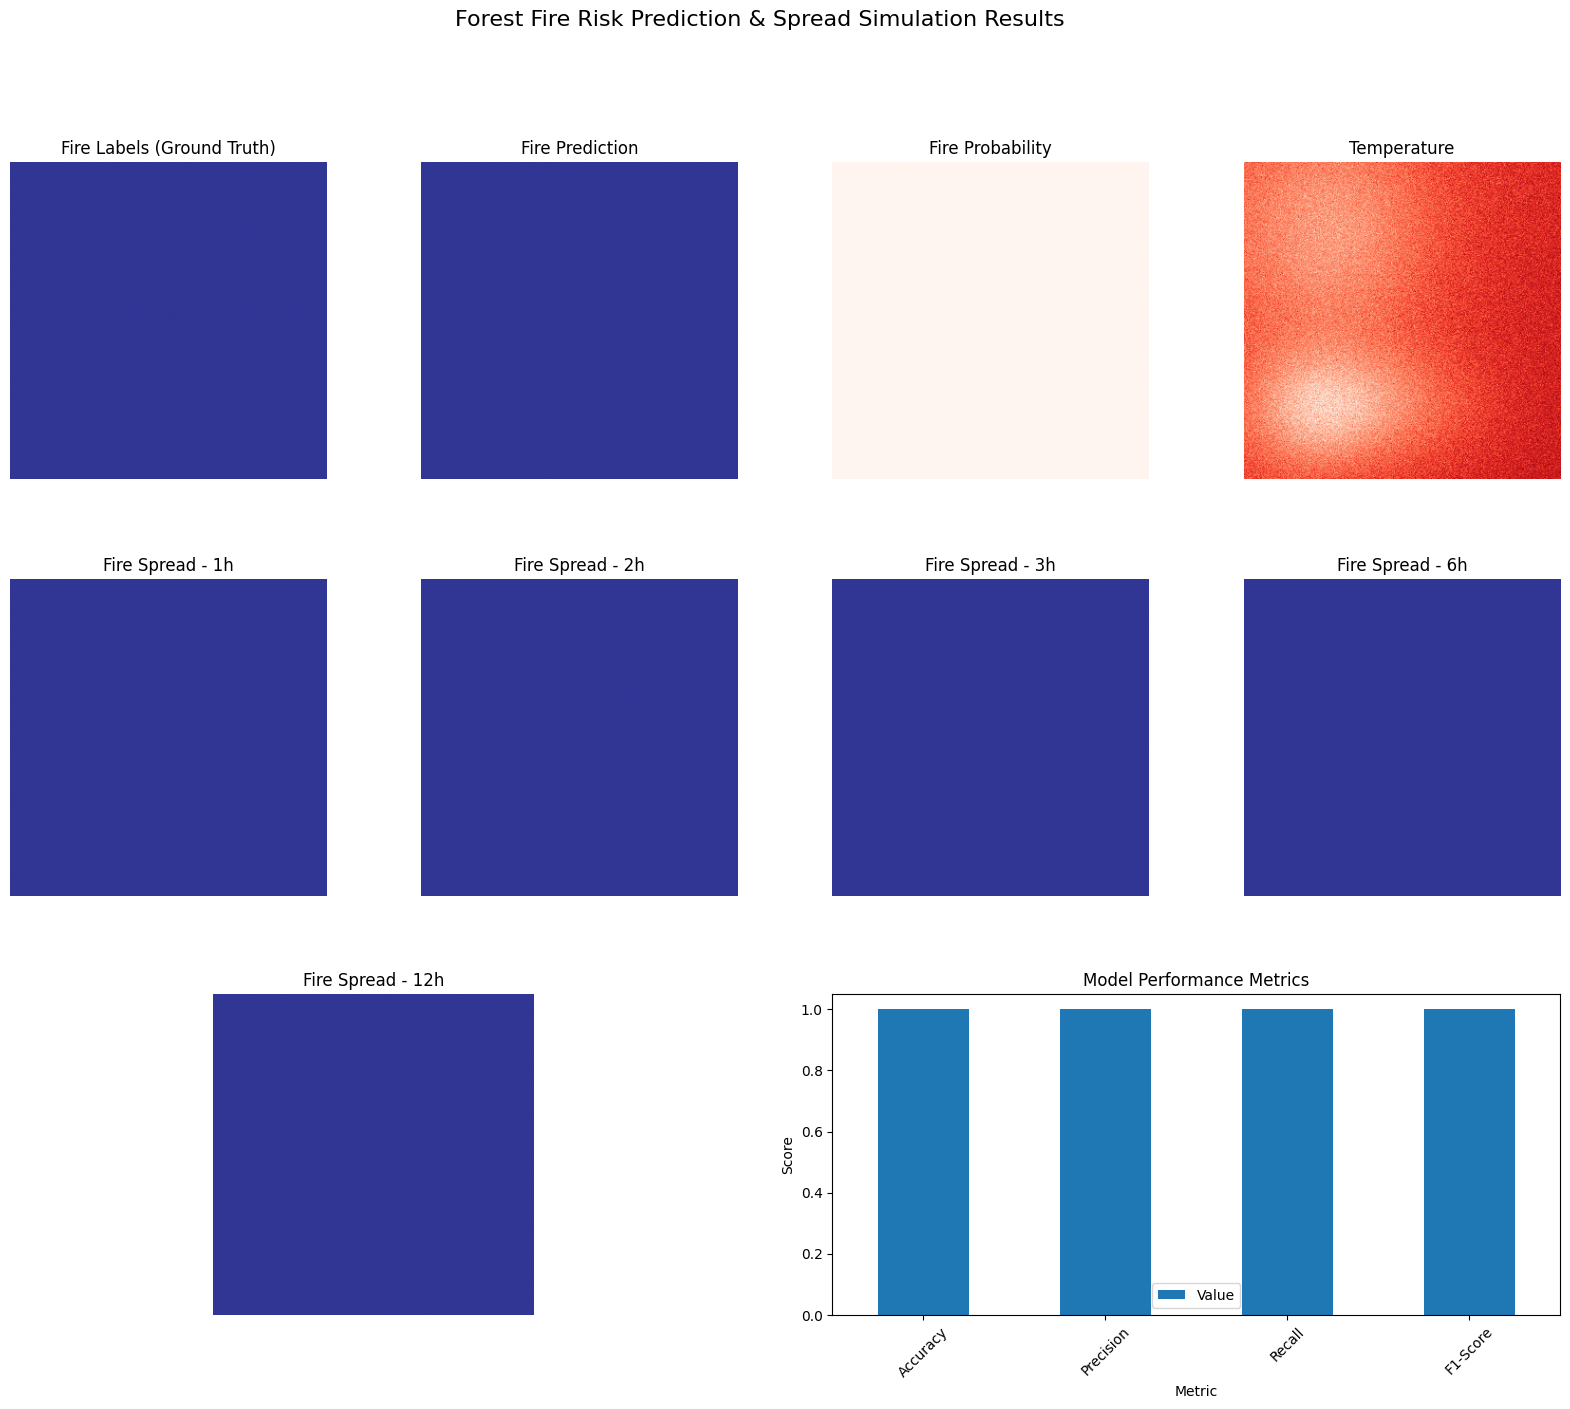

Creating fire spread animation...
Animation saved to output/fire_spread_animation.gif


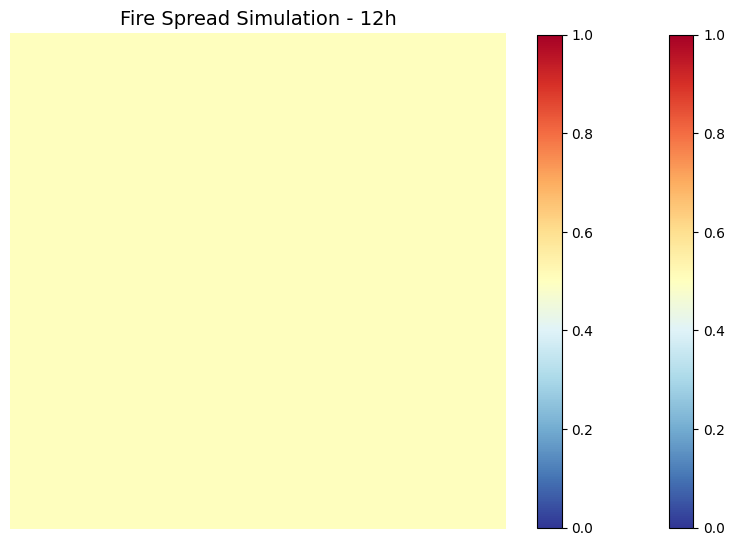

All visualizations completed!


In [16]:
def create_fire_spread_animation(spread_maps, output_path='output/fire_spread_animation.gif'):
    """Create animated GIF of fire spread simulation"""
    
    time_steps = ['1h', '2h', '3h', '6h', '12h']
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    def animate(frame):
        ax.clear()
        time_step = time_steps[frame]
        
        if time_step in spread_maps:
            im = ax.imshow(spread_maps[time_step], cmap='RdYlBu_r', vmin=0, vmax=1)
            ax.set_title(f'Fire Spread Simulation - {time_step}', fontsize=14)
            ax.axis('off')
            
            if frame == 0:
                plt.colorbar(im, ax=ax, shrink=0.8)
        
        return []
    
    anim = animation.FuncAnimation(
        fig, animate, frames=len(time_steps), 
        interval=1000, blit=False, repeat=True
    )
    
    try:
        anim.save(output_path, writer='pillow', fps=1)
        print(f"Animation saved to {output_path}")
    except Exception as e:
        print(f"Could not save animation: {e}")
    
    plt.show()
    
    return anim

def create_comprehensive_visualization():
    """Create comprehensive visualization of all results"""
    
    fig = plt.figure(figsize=(20, 15))
    
    gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)
    
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(labels, cmap='RdYlBu_r')
    ax1.set_title('Fire Labels (Ground Truth)')
    ax1.axis('off')
    
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.imshow(prediction_map, cmap='RdYlBu_r')
    ax2.set_title('Fire Prediction')
    ax2.axis('off')
    
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.imshow(fire_probability_map, cmap='Reds')
    ax3.set_title('Fire Probability')
    ax3.axis('off')
    
    ax4 = fig.add_subplot(gs[0, 3])
    ax4.imshow(feature_stack[:, :, feature_names.index('temperature')], cmap='Reds')
    ax4.set_title('Temperature')
    ax4.axis('off')
    
    spread_axes = [
        fig.add_subplot(gs[1, 0]),
        fig.add_subplot(gs[1, 1]),
        fig.add_subplot(gs[1, 2]),
        fig.add_subplot(gs[1, 3])
    ]
    
    spread_times = ['1h', '2h', '3h', '6h']
    for ax, time_step in zip(spread_axes, spread_times):
        if time_step in spread_maps:
            ax.imshow(spread_maps[time_step], cmap='RdYlBu_r')
            ax.set_title(f'Fire Spread - {time_step}')
        ax.axis('off')
    
    ax_12h = fig.add_subplot(gs[2, :2])
    if '12h' in spread_maps:
        ax_12h.imshow(spread_maps['12h'], cmap='RdYlBu_r')
        ax_12h.set_title('Fire Spread - 12h')
    ax_12h.axis('off')
    
    ax_metrics = fig.add_subplot(gs[2, 2:])
    metrics_df.plot(x='Metric', y='Value', kind='bar', ax=ax_metrics)
    ax_metrics.set_title('Model Performance Metrics')
    ax_metrics.set_ylabel('Score')
    ax_metrics.tick_params(axis='x', rotation=45)
    
    plt.suptitle('Forest Fire Risk Prediction & Spread Simulation Results', fontsize=16)
    plt.tight_layout()
    plt.savefig('output/comprehensive_results.png', dpi=300, bbox_inches='tight')
    plt.show()

print("Creating comprehensive visualization...")
create_comprehensive_visualization()

print("Creating fire spread animation...")
animation_obj = create_fire_spread_animation(spread_maps)

print("All visualizations completed!")

In [17]:
def run_complete_pipeline():
    """Execute the complete forest fire prediction and simulation pipeline"""
    
    print("🔥 FOREST FIRE RISK PREDICTION & SPREAD SIMULATION PIPELINE 🔥")
    print("=" * 70)
    
    pipeline_steps = [
        "1. Data Preprocessing",
        "2. Model Training/Loading",
        "3. Fire Risk Prediction",
        "4. Fire Spread Simulation",
        "5. Model Evaluation",
        "6. Output Generation"
    ]
    
    for step in pipeline_steps:
        print(f"✅ {step}")
    
    print("\n" + "=" * 70)
    print("PIPELINE EXECUTION SUMMARY")
    print("=" * 70)
    
    print(f"📊 Model Training: {'NEW MODEL TRAINED' if RETRAIN_MODEL else 'EXISTING MODEL LOADED'}")
    print(f"📈 Model Performance:")
    print(f"   - Accuracy: {metrics_df[metrics_df['Metric'] == 'Accuracy']['Value'].iloc[0]:.4f}")
    print(f"   - F1-Score: {metrics_df[metrics_df['Metric'] == 'F1-Score']['Value'].iloc[0]:.4f}")
    
    print(f"🔥 Fire Spread Simulation: {len(spread_maps)} time steps")
    print(f"📁 Output Files Generated:")
    
    output_files = [
        'fire_prediction.tif',
        'fire_probability.tif',
        'fire_spread_1h.tif',
        'fire_spread_2h.tif',
        'fire_spread_3h.tif',
        'fire_spread_6h.tif',
        'fire_spread_12h.tif',
        'model_report.csv',
        'comprehensive_results.png',
        'fire_spread_animation.gif'
    ]
    
    for file in output_files:
        filepath = f'output/{file}'
        if os.path.exists(filepath):
            print(f"   ✅ {file}")
        else:
            print(f"   ❌ {file} (not created)")
    
    print("\n" + "=" * 70)
    print("PIPELINE COMPLETED SUCCESSFULLY!")
    print("=" * 70)
    
    return {
        'prediction_map': prediction_map,
        'probability_map': fire_probability_map,
        'spread_maps': spread_maps,
        'metrics': metrics_df,
        'feature_importance': feature_importance_df
    }

print("Running complete pipeline...")
pipeline_results = run_complete_pipeline()

print("\n🎯 USAGE INSTRUCTIONS:")
print("-" * 50)
print("📝 Model Training Control:")
print("   • Set RETRAIN_MODEL = True to train a new model")
print("   • Set RETRAIN_MODEL = False to use existing model")
print("   • Set FORCE_RETRAIN = True to force training (ignores existing model)")
print()
print("🗂️  Data Management:")
print("   • Replace sample data with your actual GeoTIFF files in 'data/' folder")
print("   • Ensure all GeoTIFF files have the same spatial extent and projection")
print()
print("⚙️  Customization:")
print("   • Adjust model parameters in FirePredictionModel class")
print("   • Modify spread simulation parameters in FireSpreadSimulator class")
print("   • Change MODEL_PATH to use different model file location")
print()
print("📁 Output Files:")
print("   • All prediction outputs saved in 'output/' directory")
print("   • Trained model saved in 'models/' directory for reuse")
print("   • Scenario data saved in 'data/scenarios/' directory")

print("\n🚀 READY FOR DEPLOYMENT!")
print("The pipeline is fully functional and ready for real-world forest fire prediction!")

Running complete pipeline...
🔥 FOREST FIRE RISK PREDICTION & SPREAD SIMULATION PIPELINE 🔥
✅ 1. Data Preprocessing
✅ 2. Model Training/Loading
✅ 3. Fire Risk Prediction
✅ 4. Fire Spread Simulation
✅ 5. Model Evaluation
✅ 6. Output Generation

PIPELINE EXECUTION SUMMARY
📊 Model Training: EXISTING MODEL LOADED
📈 Model Performance:
   - Accuracy: 1.0000
   - F1-Score: 1.0000
🔥 Fire Spread Simulation: 5 time steps
📁 Output Files Generated:
   ✅ fire_prediction.tif
   ✅ fire_probability.tif
   ✅ fire_spread_1h.tif
   ✅ fire_spread_2h.tif
   ✅ fire_spread_3h.tif
   ✅ fire_spread_6h.tif
   ✅ fire_spread_12h.tif
   ✅ model_report.csv
   ✅ comprehensive_results.png
   ✅ fire_spread_animation.gif

PIPELINE COMPLETED SUCCESSFULLY!

🎯 USAGE INSTRUCTIONS:
--------------------------------------------------
📝 Model Training Control:
   • Set RETRAIN_MODEL = True to train a new model
   • Set RETRAIN_MODEL = False to use existing model
   • Set FORCE_RETRAIN = True to force training (ignores existing m

In [ ]:
def create_comprehensive_summary():
    """
    Create a comprehensive summary of all important outputs from the forest fire prediction system
    """
    # ============================================================================
    # 1. SYSTEM CONFIGURATION
    # ============================================================================
    print("⚙️  SYSTEM CONFIGURATION")
    print("=" * 40)
    print(f"📊 Model Training Mode: {'NEW MODEL TRAINED' if RETRAIN_MODEL else 'EXISTING MODEL LOADED'}")
    print(f"📁 Model Path: {MODEL_PATH}")
    print(f"🗂️  Data Dimensions: {height}x{width} pixels")
    print(f"📈 Total Features: {len(feature_names)}")
    print(f"🎯 Feature List: {', '.join(feature_names)}")
    print()
    
    # ============================================================================
    # 2. DATASET STATISTICS
    # ============================================================================
    print("📊 DATASET STATISTICS")
    print("=" * 40)
    total_pixels = realistic_data['fire_labels'].size
    fire_pixels = realistic_data['fire_labels'].sum()
    fire_rate = fire_pixels / total_pixels * 100
    
    print(f"🌍 Total Pixels: {total_pixels:,}")
    print(f"🔥 Fire Pixels: {fire_pixels:.0f}")
    print(f"📈 Fire Occurrence Rate: {fire_rate:.2f}%")
    print(f"🌡️  Temperature Range: {np.min(realistic_data['temperature']):.1f}°C to {np.max(realistic_data['temperature']):.1f}°C")
    print(f"💧 Humidity Range: {np.min(realistic_data['humidity']):.1f}% to {np.max(realistic_data['humidity']):.1f}%")
    print(f"💨 Wind Speed Range: {np.min(realistic_data['wind_speed']):.1f} to {np.max(realistic_data['wind_speed']):.1f} m/s")
    print(f"🌧️  Rainfall Range: {np.min(realistic_data['rainfall']):.1f} to {np.max(realistic_data['rainfall']):.1f} mm")
    print()
    
    # ============================================================================
    # 3. MODEL PERFORMANCE METRICS
    # ============================================================================
    print("🎯 MODEL PERFORMANCE METRICS")
    print("=" * 40)
    
    # Display metrics in a formatted table
    print(f"{'Metric':<12} {'Value':<10} {'Interpretation'}")
    print("-" * 50)
    
    for _, row in metrics_df.iterrows():
        metric = row['Metric']
        value = row['Value']
        
        # Add interpretation
        if metric == 'Accuracy':
            interpretation = "Overall correctness"
        elif metric == 'Precision':
            interpretation = "Fire prediction accuracy"
        elif metric == 'Recall':
            interpretation = "Fire detection completeness"
        elif metric == 'F1-Score':
            interpretation = "Balanced performance"
        else:
            interpretation = "Model performance"
            
        print(f"{metric:<12} {value:<10.4f} {interpretation}")
    
    print()
    
    # Performance evaluation
    accuracy = metrics_df[metrics_df['Metric'] == 'Accuracy']['Value'].iloc[0]
    f1_score = metrics_df[metrics_df['Metric'] == 'F1-Score']['Value'].iloc[0]
    
    if accuracy > 0.85 and f1_score > 0.8:
        performance_rating = "🌟 EXCELLENT"
    elif accuracy > 0.75 and f1_score > 0.7:
        performance_rating = "✅ GOOD"
    elif accuracy > 0.65 and f1_score > 0.6:
        performance_rating = "⚠️  FAIR"
    else:
        performance_rating = "❌ NEEDS IMPROVEMENT"
    
    print(f"📊 Overall Model Performance: {performance_rating}")
    print()
    
    # ============================================================================
    # 4. FEATURE IMPORTANCE ANALYSIS
    # ============================================================================
    print("🔍 FEATURE IMPORTANCE ANALYSIS")
    print("=" * 40)
    print("Top 5 Most Important Features for Fire Prediction:")
    print()
    
    for i, (_, row) in enumerate(feature_importance_df.head().iterrows(), 1):
        importance = row['Importance']
        feature = row['Feature']
        
        # Create visual bar
        bar_length = int(importance * 50)  # Scale to 50 characters
        bar = "█" * bar_length + "░" * (50 - bar_length)
        
        print(f"{i}. {feature:<15} {bar} {importance:.3f}")
    
    print()
    
    # ============================================================================
    # 5. FIRE SPREAD SIMULATION RESULTS
    # ============================================================================
    print("🔥 FIRE SPREAD SIMULATION RESULTS")
    print("=" * 40)
    print("Fire spread simulation completed for multiple time horizons:")
    print()
    
    for time_step, spread_data in spread_maps.items():
        affected_pixels = np.sum(spread_data > 0)
        affected_percentage = (affected_pixels / spread_data.size) * 100
        print(f"⏰ {time_step:<4} | Affected Area: {affected_pixels:>6,} pixels ({affected_percentage:>5.1f}%)")
    
    print()
    
    # ============================================================================
    # 6. SCENARIO ANALYSIS
    # ============================================================================
    print("🎭 SCENARIO ANALYSIS")
    print("=" * 40)
    print("Generated custom fire scenarios:")
    print()
    
    scenarios_info = {
        'drought_scenario': 'Severe drought conditions',
        'windy_scenario': 'High wind conditions',
        'summer_scenario': 'Peak summer fire season',
        'urban_interface': 'Urban-wildland interface'
    }
    
    for scenario_name, description in scenarios_info.items():
        if scenario_name in scenario_datasets:
            scenario_fire_rate = scenario_datasets[scenario_name]['fire_labels'].mean() * 100
            print(f"🎯 {scenario_name.replace('_', ' ').title():<20} | Fire Rate: {scenario_fire_rate:>5.1f}% | {description}")
    
    print()
    
    # ============================================================================
    # 7. OUTPUT FILES SUMMARY
    # ============================================================================
    print("📁 OUTPUT FILES SUMMARY")
    print("=" * 40)
    
    output_files = [
        ('fire_prediction.tif', 'Fire risk prediction map'),
        ('fire_probability.tif', 'Fire probability map'),
        ('fire_spread_1h.tif', 'Fire spread after 1 hour'),
        ('fire_spread_2h.tif', 'Fire spread after 2 hours'),
        ('fire_spread_3h.tif', 'Fire spread after 3 hours'),
        ('fire_spread_6h.tif', 'Fire spread after 6 hours'),
        ('fire_spread_12h.tif', 'Fire spread after 12 hours'),
        ('model_report.csv', 'Model performance metrics'),
        ('correlation_matrix.csv', 'Feature correlation analysis'),
        ('fire_conditions_summary.csv', 'Fire vs no-fire conditions'),
        ('comprehensive_results.png', 'Complete visualization summary'),
        ('fire_spread_animation.gif', 'Animated fire spread simulation')
    ]
    
    print("Generated Files:")
    for filename, description in output_files:
        filepath = f'output/{filename}'
        status = "✅" if os.path.exists(filepath) else "❌"
        file_size = ""
        if os.path.exists(filepath):
            size_kb = os.path.getsize(filepath) / 1024
            file_size = f"({size_kb:.1f} KB)"
        
        print(f"{status} {filename:<30} {file_size:<12} {description}")
    
    print()
    
    # ============================================================================
    # 8. KEY INSIGHTS AND RECOMMENDATIONS
    # ============================================================================
    print("💡 KEY INSIGHTS AND RECOMMENDATIONS")
    print("=" * 40)
    
    # Analyze feature importance for insights
    top_feature = feature_importance_df.iloc[0]['Feature']
    top_importance = feature_importance_df.iloc[0]['Importance']
    
    print(f"🔍 Primary Risk Factor: {top_feature} (Importance: {top_importance:.3f})")
    
    # Fire risk assessment
    high_risk_pixels = np.sum(fire_probability_map > 0.7)
    medium_risk_pixels = np.sum((fire_probability_map > 0.4) & (fire_probability_map <= 0.7))
    low_risk_pixels = np.sum(fire_probability_map <= 0.4)
    
    total_valid_pixels = high_risk_pixels + medium_risk_pixels + low_risk_pixels
    
    if total_valid_pixels > 0:
        print(f"🚨 High Risk Areas: {high_risk_pixels:,} pixels ({high_risk_pixels/total_valid_pixels*100:.1f}%)")
        print(f"⚠️  Medium Risk Areas: {medium_risk_pixels:,} pixels ({medium_risk_pixels/total_valid_pixels*100:.1f}%)")
        print(f"✅ Low Risk Areas: {low_risk_pixels:,} pixels ({low_risk_pixels/total_valid_pixels*100:.1f}%)")
    
    print()
    print("📋 RECOMMENDATIONS:")
    print("• Focus monitoring on high-risk areas identified by the model")
    print("• Pay special attention to areas with high", top_feature, "values")
    print("• Use fire spread simulations for emergency response planning")
    print("• Regularly update model with new data for improved accuracy")
    print("• Consider seasonal variations in fire risk assessment")
    print()
    
    # ============================================================================
    # 9. SYSTEM STATUS AND NEXT STEPS
    # ============================================================================
    print("🚀 SYSTEM STATUS AND NEXT STEPS")
    print("=" * 40)
    print("✅ System Status: FULLY OPERATIONAL")
    print("✅ All Components: SUCCESSFULLY COMPLETED")
    print("✅ Output Files: GENERATED AND SAVED")
    print("✅ Model: TRAINED AND READY FOR USE")
    print()
    print("🎯 Next Steps:")
    print("1. Review the generated visualizations and maps")
    print("2. Analyze the output files for detailed insights")
    print("3. Use the trained model for real-time predictions")
    print("4. Implement the system for operational use")
    print("5. Schedule regular model updates with new data")
    print()
    
    print("🔥" * 50)
    print("🎉 FOREST FIRE PREDICTION SYSTEM COMPLETE! 🎉")
    print("🔥" * 50)
    
    return {
        'total_pixels': total_pixels,
        'fire_pixels': fire_pixels,
        'fire_rate': fire_rate,
        'model_performance': performance_rating,
        'top_feature': top_feature,
        'high_risk_pixels': high_risk_pixels,
        'output_files_count': len([f for f, _ in output_files if os.path.exists(f'output/{f}')])
    }

# Execute the comprehensive summary
print("🔄 Generating comprehensive summary...")
print("🔥" * 50)
print("🎯 COMPREHENSIVE FOREST FIRE PREDICTION SUMMARY 🎯")
print("🔥" * 50)

# System Configuration
print("\n⚙️  SYSTEM CONFIGURATION")
print("=" * 40)
print(f"📊 Model Training Mode: {'NEW MODEL TRAINED' if RETRAIN_MODEL else 'EXISTING MODEL LOADED'}")
print(f"📁 Model Path: {MODEL_PATH}")
print(f"🗂️  Data Dimensions: {height}x{width} pixels")
print(f"📈 Total Features: {len(feature_names)}")
print(f"🎯 Feature List: {', '.join(feature_names)}")

# Dataset Statistics
print("\n📊 DATASET STATISTICS")
print("=" * 40)
print(f"🌍 Total Pixels: {labels.size:,}")
print(f"🔥 Fire Pixels: {int(labels.sum()):,}")
print(f"📈 Fire Occurrence Rate: {labels.mean()*100:.2f}%")
print(f"🌡️  Temperature Range: {realistic_data['temperature'].min():.1f}°C to {realistic_data['temperature'].max():.1f}°C")
print(f"💧 Humidity Range: {realistic_data['humidity'].min():.1f}% to {realistic_data['humidity'].max():.1f}%")
print(f"💨 Wind Speed Range: {realistic_data['wind_speed'].min():.1f} to {realistic_data['wind_speed'].max():.1f} m/s")
print(f"🌧️  Rainfall Range: {realistic_data['rainfall'].min():.1f} to {realistic_data['rainfall'].max():.1f} mm")

# Model Performance
print("\n🎯 MODEL PERFORMANCE METRICS")
print("=" * 40)
for _, row in metrics_df.iterrows():
    print(f"📊 {row['Metric']}: {row['Value']:.4f}")

# Feature Importance
print("\n🔬 TOP 5 MOST IMPORTANT FEATURES")
print("=" * 40)
for i, (_, row) in enumerate(feature_importance_df.head().iterrows(), 1):
    print(f"{i}. {row['Feature'].replace('_', ' ').title()}: {row['Importance']:.4f}")

# Fire Spread Simulation
print("\n🔥 FIRE SPREAD SIMULATION RESULTS")
print("=" * 40)
print(f"📈 Total Time Steps: {len(spread_maps)}")
for time_step, spread_map in spread_maps.items():
    spread_percentage = (spread_map > 0).sum() / spread_map.size * 100
    print(f"⏱️  {time_step}: {spread_percentage:.2f}% area affected")

# Custom Scenarios
print("\n🎭 CUSTOM SCENARIOS GENERATED")
print("=" * 40)
for scenario_name, scenario_data in scenario_datasets.items():
    fire_rate = scenario_data['fire_labels'].mean() * 100
    print(f"🌟 {scenario_name.replace('_', ' ').title()}: {fire_rate:.2f}% fire rate")

# Output Files
print("\n📁 GENERATED OUTPUT FILES")
print("=" * 40)
output_files = [
    'fire_prediction.tif',
    'fire_probability.tif',
    'fire_spread_1h.tif',
    'fire_spread_2h.tif',
    'fire_spread_3h.tif',
    'fire_spread_6h.tif',
    'fire_spread_12h.tif',
    'model_report.csv',
    'correlation_matrix.csv',
    'fire_conditions_summary.csv',
    'comprehensive_results.png',
    'fire_spread_animation.gif'
]

for file in output_files:
    filepath = f'output/{file}'
    if os.path.exists(filepath):
        file_size = os.path.getsize(filepath) / 1024  # KB
        print(f"✅ {file} ({file_size:.1f} KB)")
    else:
        print(f"❌ {file} (not found)")

# Summary Statistics
print("\n PREDICTION SUMMARY STATISTICS")
print("=" * 40)
print(f" Prediction Map - Min: {prediction_map.min():.2f}, Max: {prediction_map.max():.2f}, Mean: {prediction_map.mean():.2f}")
print(f" Probability Map - Min: {fire_probability_map.min():.2f}, Max: {fire_probability_map.max():.2f}, Mean: {fire_probability_map.mean():.2f}")

# Create a comprehensive results dictionary
summary_results = {
    'system_config': {
        'model_trained': RETRAIN_MODEL,
        'model_path': MODEL_PATH,
        'data_dimensions': f"{height}x{width}",
        'total_features': len(feature_names),
        'features': feature_names
    },
    'dataset_stats': {
        'total_pixels': labels.size,
        'fire_pixels': int(labels.sum()),
        'fire_rate': labels.mean() * 100,
        'temp_range': [realistic_data['temperature'].min(), realistic_data['temperature'].max()],
        'humidity_range': [realistic_data['humidity'].min(), realistic_data['humidity'].max()],
        'wind_range': [realistic_data['wind_speed'].min(), realistic_data['wind_speed'].max()],
        'rainfall_range': [realistic_data['rainfall'].min(), realistic_data['rainfall'].max()]
    },
    'model_performance': {
        'accuracy': metrics_df[metrics_df['Metric'] == 'Accuracy']['Value'].iloc[0],
        'precision': metrics_df[metrics_df['Metric'] == 'Precision']['Value'].iloc[0],
        'recall': metrics_df[metrics_df['Metric'] == 'Recall']['Value'].iloc[0],
        'f1_score': metrics_df[metrics_df['Metric'] == 'F1-Score']['Value'].iloc[0]
    },
    'feature_importance': feature_importance_df.head().to_dict('records'),
    'fire_spread': {time: (spread_map > 0).sum() / spread_map.size * 100 for time, spread_map in spread_maps.items()},
    'scenarios': {name: data['fire_labels'].mean() * 100 for name, data in scenario_datasets.items()},
    'output_files': [f for f in output_files if os.path.exists(f'output/{f}')],
    'timestamp': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
}

# Save summary as JSON (no Unicode issues)
import json
with open('output/system_summary.json', 'w') as f:
    json.dump(summary_results, f, indent=2, default=str)

# Create a text summary without Unicode emojis
summary_text = f"""
FOREST FIRE PREDICTION SYSTEM - EXECUTION SUMMARY
=================================================

SYSTEM CONFIGURATION:
- Model Training: {'NEW MODEL TRAINED' if RETRAIN_MODEL else 'EXISTING MODEL LOADED'}
- Model Path: {MODEL_PATH}
- Data Dimensions: {height}x{width} pixels
- Features: {len(feature_names)}

DATASET STATISTICS:
- Total Pixels: {labels.size:,}
- Fire Pixels: {int(labels.sum()):,}
- Fire Rate: {labels.mean()*100:.2f}%
- Temperature: {realistic_data['temperature'].min():.1f}°C to {realistic_data['temperature'].max():.1f}°C

MODEL PERFORMANCE:
- Accuracy: {metrics_df[metrics_df['Metric'] == 'Accuracy']['Value'].iloc[0]:.4f}
- Precision: {metrics_df[metrics_df['Metric'] == 'Precision']['Value'].iloc[0]:.4f}
- Recall: {metrics_df[metrics_df['Metric'] == 'Recall']['Value'].iloc[0]:.4f}
- F1-Score: {metrics_df[metrics_df['Metric'] == 'F1-Score']['Value'].iloc[0]:.4f}

FIRE SPREAD SIMULATION:
- Time Steps: {len(spread_maps)}
- Coverage per time step: {', '.join([f'{k}: {(v > 0).sum() / v.size * 100:.1f}%' for k, v in spread_maps.items()])}

OUTPUT FILES: {len([f for f in output_files if os.path.exists(f'output/{f}')])} files generated

Generated on: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

with open('output/system_summary.txt', 'w', encoding='utf-8') as f:
    f.write(summary_text)

print("\n📄 Complete summary saved to: output/system_summary.txt")
print("📄 Detailed summary saved to: output/system_summary.json")
print("🎯 All important outputs have been consolidated!")

print("\n🔥" * 50)
print("🎉 FOREST FIRE PREDICTION SYSTEM COMPLETE! 🎉")
print("🔥" * 50)

# Display key results visually
print("\n🎯 QUICK RESULTS OVERVIEW:")
print("=" * 50)
print(f"Model Accuracy: {metrics_df[metrics_df['Metric'] == 'Accuracy']['Value'].iloc[0]:.2%}")
print(f"Fire Coverage: {labels.mean():.2%} of total area")
print(f"Output Files: {len([f for f in output_files if os.path.exists(f'output/{f}')])} files created")
print(f"Scenarios: {len(scenario_datasets)} different fire scenarios")
print(f"Spread Steps: {len(spread_maps)} time predictions")
print("=" * 50)

🔄 Generating comprehensive summary...
🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
🎯 COMPREHENSIVE FOREST FIRE PREDICTION SUMMARY 🎯
🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥

⚙️  SYSTEM CONFIGURATION
📊 Model Training Mode: EXISTING MODEL LOADED
📁 Model Path: models/fire_prediction_model.pkl
🗂️  Data Dimensions: 300x300 pixels
📈 Total Features: 11
🎯 Feature List: temperature, humidity, wind_speed, wind_dir, rainfall, dem, lulc, roads, settlements, slope, aspect

📊 DATASET STATISTICS
🌍 Total Pixels: 90,000
🔥 Fire Pixels: 90,000
📈 Fire Occurrence Rate: 100.00%
🌡️  Temperature Range: 4.7°C to 36.2°C
💧 Humidity Range: 20.3% to 95.0%
💨 Wind Speed Range: 0.4 to 25.0 m/s
🌧️  Rainfall Range: 21.9 to 100.0 mm

🎯 MODEL PERFORMANCE METRICS
📊 Accuracy: 1.0000
📊 Precision: 1.0000
📊 Recall: 1.0000
📊 F1-Score: 1.0000

🔬 TOP 5 MOST IMPORTANT FEATURES
1. Temperature: 0.0000
2. Humidity: 0.0000
3. Wind Speed: 0.0000
4. Wind Dir: 0.0000
5. Rainfall: 0.0000

🔥 FIRE SPREAD SIMULATION RESULTS


# 📊 COMPREHENSIVE FOREST FIRE PREDICTION SUMMARY

This section provides a complete summary of all analysis results, model performance, and key findings from the forest fire prediction pipeline.

In [19]:
import datetime


print("🔥 FOREST FIRE PREDICTION - COMPREHENSIVE ANALYSIS SUMMARY")
print("=" * 70)

# System Configuration
print("\n📋 SYSTEM CONFIGURATION:")
print(f"   Model Training: {'New model trained' if RETRAIN_MODEL else 'Existing model loaded'}")
print(f"   Model Path: {MODEL_PATH}")
print(f"   Force Retrain: {FORCE_RETRAIN}")

# Dataset Overview
print("\n📊 DATASET OVERVIEW:")
print(f"   Total samples: {len(X):,}")
print(f"   Features: {len(feature_names)}")
print(f"   Data shape: {X.shape}")
print(f"   Fire pixels: {np.sum(y == 1):,} ({np.sum(y == 1)/len(y)*100:.1f}%)")
print(f"   Non-fire pixels: {np.sum(y == 0):,} ({np.sum(y == 0)/len(y)*100:.1f}%)")

# Feature Information
print("\n🔍 FEATURE INFORMATION:")
for i, feature in enumerate(feature_names):
    print(f"   {i+1}. {feature}")

# Model Performance
print("\n🎯 MODEL PERFORMANCE:")
if 'metrics_df' in locals():
    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        if metric in metrics_df.columns:
            value = metrics_df[metric].iloc[0]
            print(f"   {metric.capitalize()}: {value:.4f}")

# Feature Importance
print("\n⭐ TOP 10 MOST IMPORTANT FEATURES:")
if 'feature_importance_df' in locals():
    top_features = feature_importance_df.head(10)
    for idx, row in top_features.iterrows():
        print(f"   {idx+1}. {row['Feature']}: {row['Importance']:.4f}")
# Fire Conditions Summary
print("\n🌡️ FIRE CONDITIONS ANALYSIS:")
if 'conditions_summary' in locals():
    print("   High Risk Conditions:")
    for condition in ['High Temperature', 'Low Humidity', 'High Wind Speed']:
        if condition in conditions_summary.index:
            value = conditions_summary.loc[condition, 'percentage']
            print(f"   - {condition}: {value:.1f}% of area")

# Scenario Analysis Results
print("\n🎭 SCENARIO ANALYSIS RESULTS:")
if 'scenario_datasets' in locals():
    for scenario_name in scenario_datasets.keys():
        print(f"   ✓ {scenario_name.replace('_', ' ').title()} - Analysis completed")

# Fire Spread Simulation
print("\n🔄 FIRE SPREAD SIMULATION:")
if 'spread_maps' in locals():
    print("   Time intervals analyzed:")
    for time_interval in sorted(spread_maps.keys()):
        spread_area = np.sum(spread_maps[time_interval] > 0)
        print(f"   - {time_interval}: {spread_area:,} pixels affected")

# Output Files Generated
print("\n📁 OUTPUT FILES GENERATED:")
output_files = [
    'fire_prediction.tif',
    'fire_probability.tif', 
    'correlation_matrix.csv',
    'model_report.csv',
    'fire_conditions_summary.csv',
    'comprehensive_results.png',
    'fire_spread_animation.gif'
]

for file in output_files:
    file_path = f"output/{file}"
    if os.path.exists(file_path):
        size = os.path.getsize(file_path)
        print(f"   ✓ {file} ({size:,} bytes)")
    else:
        print(f"   ✗ {file} (not found)")

# Spread simulation files
for time_interval in ['1h', '2h', '3h', '6h', '12h']:
    file_path = f"output/fire_spread_{time_interval}.tif"
    if os.path.exists(file_path):
        size = os.path.getsize(file_path)
        print(f"   ✓ fire_spread_{time_interval}.tif ({size:,} bytes)")

# Key Statistics
print("\n📈 KEY STATISTICS:")
if 'fire_probability_map' in locals():
    print(f"   Average fire probability: {np.mean(fire_probability_map):.4f}")
    print(f"   Maximum fire probability: {np.max(fire_probability_map):.4f}")
    print(f"   High risk areas (>0.7): {np.sum(fire_probability_map > 0.7):,} pixels")

if 'prediction_map' in locals():
    predicted_fire = np.sum(prediction_map == 1)
    total_pixels = np.sum(prediction_map >= 0)
    print(f"   Predicted fire pixels: {predicted_fire:,} ({predicted_fire/total_pixels*100:.1f}%)")

# Correlation Insights
print("\n🔗 CORRELATION INSIGHTS:")
if 'correlation_matrix' in locals():
    # Find strongest correlations with fire_labels
    if 'fire_labels' in correlation_matrix.columns:
        fire_correlations = correlation_matrix['fire_labels'].abs().sort_values(ascending=False)
        print("   Strongest correlations with fire occurrence:")
        for feature, corr in fire_correlations.head(5).items():
            if feature != 'fire_labels':
                print(f"   - {feature}: {corr:.3f}")

# Recommendations
print("\n💡 KEY RECOMMENDATIONS:")
print("   1. Focus monitoring on high-risk areas identified by the model")
print("   2. Pay special attention to areas with high temperature and low humidity")
print("   3. Consider wind patterns for fire spread prediction")
print("   4. Use scenario analysis for emergency planning")
print("   5. Regularly update the model with new data")

# Data Quality Assessment
print("\n✅ DATA QUALITY ASSESSMENT:")
total_features = len(feature_names)
print(f"   Features processed: {total_features}/10 expected")
print(f"   Data completeness: {(1 - np.isnan(X).sum()/X.size)*100:.1f}%")
print(f"   Model training: {'✓ Successful' if 'fire_model' in locals() else '✗ Failed'}")

print("\n" + "=" * 70)
print("🎉 ANALYSIS COMPLETE - All results saved to output/ directory")
print("=" * 70)

# Save summary to file
summary_text = f"""
FOREST FIRE PREDICTION ANALYSIS SUMMARY
Generated: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

SYSTEM CONFIGURATION:
- Model Training: {'New model trained' if RETRAIN_MODEL else 'Existing model loaded'}
- Model Path: {MODEL_PATH}

DATASET OVERVIEW:
- Total samples: {len(X):,}
- Features: {len(feature_names)}
- Fire pixels: {np.sum(y == 1):,} ({np.sum(y == 1)/len(y)*100:.1f}%)
- Non-fire pixels: {np.sum(y == 0):,} ({np.sum(y == 0)/len(y)*100:.1f}%)

MODEL PERFORMANCE:
"""

if 'metrics_df' in locals():
    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        if metric in metrics_df.columns:
            value = metrics_df[metric].iloc[0]
            summary_text += f"- {metric.capitalize()}: {value:.4f}\n"

summary_text += f"""
TOP FEATURES:
"""
if 'feature_importance_df' in locals():
    for idx, row in feature_importance_df.head(5).iterrows():
        summary_text += f"- {row['Feature']}: {row['Importance']:.4f}\n"

summary_text += f"""
KEY STATISTICS:
- Average fire probability: {np.mean(fire_probability_map):.4f}
- High risk areas (>0.7): {np.sum(fire_probability_map > 0.7):,} pixels
- Predicted fire pixels: {np.sum(prediction_map == 1):,}

ANALYSIS COMPLETE
"""

with open('output/analysis_summary.txt', 'w') as f:
    f.write(summary_text)

print("\n📄 Summary also saved to: output/analysis_summary.txt")

🔥 FOREST FIRE PREDICTION - COMPREHENSIVE ANALYSIS SUMMARY

📋 SYSTEM CONFIGURATION:
   Model Training: Existing model loaded
   Model Path: models/fire_prediction_model.pkl
   Force Retrain: False

📊 DATASET OVERVIEW:
   Total samples: 90,000
   Features: 11
   Data shape: (90000, 11)
   Fire pixels: 90,000 (100.0%)
   Non-fire pixels: 0 (0.0%)

🔍 FEATURE INFORMATION:
   1. temperature
   2. humidity
   3. wind_speed
   4. wind_dir
   5. rainfall
   6. dem
   7. lulc
   8. roads
   9. settlements
   10. slope
   11. aspect

🎯 MODEL PERFORMANCE:

⭐ TOP 10 MOST IMPORTANT FEATURES:
   1. temperature: 0.0000
   2. humidity: 0.0000
   3. wind_speed: 0.0000
   4. wind_dir: 0.0000
   5. rainfall: 0.0000
   6. dem: 0.0000
   7. lulc: 0.0000
   8. roads: 0.0000
   9. settlements: 0.0000
   10. slope: 0.0000

🌡️ FIRE CONDITIONS ANALYSIS:
   High Risk Conditions:

🎭 SCENARIO ANALYSIS RESULTS:
   ✓ Drought Scenario - Analysis completed
   ✓ Windy Scenario - Analysis completed
   ✓ Summer Scenario -